In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


### Ładowanie danych

In [35]:
def load_and_preprocess(file_path):
    data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').drop_duplicates('timestamp')
    return data

##### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def isolation_forest_IQR_window(data, column='energy_consumption', window_size=24):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]]).flatten()

    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    outlier_mask = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
    contamination = max(0.001, min(0.5, np.sum(outlier_mask) / len(values)))

    sequences = create_sequences(values, window_size)
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(sequences)

    preds = model.predict(sequences)  # -1 dla anomalii, 1 dla normalnych
    binary_preds = (preds == -1).astype(int)

    # Głosowanie przez nakładające się okna
    anomaly_scores = np.zeros(len(values))
    counts = np.zeros(len(values))

    for i in range(len(binary_preds)):
        if binary_preds[i] == 1:
            anomaly_scores[i:i+window_size] += 1
        counts[i:i+window_size] += 1

    avg_scores = np.divide(anomaly_scores, counts, out=np.zeros_like(anomaly_scores), where=counts != 0)
    final_labels = (avg_scores > 0.5).astype(int)

    data['isolation_forest'] = final_labels
    return data

def isolation_forest_95(data, column='energy_consumption', contamination_quantile=0.95):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Train initial model to get scores
    model = IsolationForest(contamination='auto')
    model.fit(values)
    scores = model.decision_function(values)  # The lower, the more abnormal

    # Estimate contamination based on quantile of scores
    threshold = np.quantile(scores, 1 - contamination_quantile)
    predicted = (scores < threshold).astype(int)

    data['isolation_forest'] = predicted
    return data

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def isolation_forest_IQR(data, column='energy_consumption', contamination=0.05):
    data = data.copy()
    
    # Check if column exists
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    # Scale the specified column
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    
    # Train Isolation Forest model
    model = IsolationForest(
        contamination="auto",
        n_estimators=500,
    )
    

    scores = model.fit_predict(values)
    decision_scores = model.decision_function(values)

    q1 = np.percentile(decision_scores, 25)
    q3 = np.percentile(decision_scores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr

    threshold = np.quantile(decision_scores, 0.01) 
    data['isolation_forest'] = decision_scores < threshold
    
    return data


##### LSTM Autoencoder

In [192]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def lstm_autoencoder(data, column='energy_consumption', window_size=24, iqr_multiplier=1.5, epochs=50, batch_size=32):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    if len(values) < window_size + 1:
        raise ValueError(f"Not enough data points ({len(values)}) for window size {window_size}")
    X = create_sequences(values, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    def build_model(hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            input_shape=(window_size, 1),
            return_sequences=False))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(RepeatVector(window_size))
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=True))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(TimeDistributed(Dense(1)))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
            loss='mse',
            metrics=['mae'])
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning',
        project_name='energy_forecast'
    )

    tuner.search(X, X, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]

    best_model.fit(X, X, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    pred = best_model.predict(X)
    mae = np.mean(np.abs(pred - X), axis=(1, 2))

    q1 = np.percentile(mae, 25)
    q3 = np.percentile(mae, 75)
    iqr = q3 - q1
    
    ub = q3 + iqr_multiplier * iqr
    lb = q1 - iqr_multiplier * iqr

    anomalies = np.zeros(len(data))
    anomaly_scores = np.zeros(len(data))
    window_counts = np.zeros(len(data))

    for i in range(len(mae)):
        if mae[i] > ub or mae[i] < lb:
            anomaly_scores[i:i + window_size] += 1
        window_counts[i:i + window_size] += 1

    anomaly_scores = np.where(window_counts > 0, anomaly_scores / window_counts, 0)
    anomalies[anomaly_scores > 0.5] = 1

    data['lstm_autoencoder'] = anomalies
    return data


##### IQR

In [407]:

def dynamic_iqr(timeseries, w=None, k=1.5):

    if isinstance(timeseries, pd.Series):
        df = pd.DataFrame({'energy consumption': timeseries.values}, index=timeseries.index)
    elif isinstance(timeseries, pd.DataFrame):
        df = timeseries.copy()
    else:
        raise ValueError("Input should be a pandas Series or DataFrame")
    
    anomalies = np.zeros(len(df), dtype=bool)

    if w is None or w >= len(df):
        Q1 = df['energy consumption'].quantile(0.25)
        Q3 = df['energy consumption'].quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - k * IQR
        ub = Q3 + k * IQR
        anomalies = (df['energy consumption'] < lb) | (df['energy consumption'] > ub)
    else:
        for i in range(len(df)):
            start = max(0, i - w // 2)
            end = min(len(df), i + w // 2)
            window = df['energy consumption'].iloc[start:end]
            Q1 = window.quantile(0.25)
            Q3 = window.quantile(0.75)
            IQR = Q3 - Q1
            lb = Q1 - k * IQR
            ub = Q3 + k * IQR
            if (df['energy consumption'].iloc[i] < lb) or (df['energy consumption'].iloc[i] > ub):
                anomalies[i] = True

    return df, anomalies


##### RUN

In [39]:

dataW = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstmW = dataW
IF_resultsW = isolation_forest_IQR_window(data=dataW)
LSTM_resultsW = lstm_autoencoder(data_lstmW, window_size=24)
timeseriesW, IQR_resultsW = dynamic_iqr(dataW['energy_consumption'], w=24, k=1.5)

data2W = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2W = data2W
IF_results2W = isolation_forest_IQR_window(data=data2W)
LSTM_results2W = lstm_autoencoder(data_lstm2W, window_size=24)
timeseries2W, IQR_results2W = dynamic_iqr(data2W['energy_consumption'], w=24, k=1.5)


data3W = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3W = data3W
IF_results3W = isolation_forest_IQR_window(data=data3W)
LSTM_results3W = lstm_autoencoder(data_lstm3W, window_size=24)
timeseries3W, IQR_results3W = dynamic_iqr(data3W['energy_consumption'], w=24, k=1.5)


Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 2.9153e-04 - mae: 0.0115 - val_loss: 5.1744e-04 - val_mae: 0.0085
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.5812e-04 - mae: 0.0076 - val_loss: 5.0771e-04 - val_mae: 0.0084
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.4335e-04 - mae: 0.0071 - val_loss: 4.8808e-04 - val_mae: 0.0084
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 1.3834e-04 - mae: 0.0068 - val_loss: 4.9230e-04 - val_mae: 0.0085
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.3343e-04 - mae: 0.0067 - val_loss: 5.1686e-04 - val_mae: 0.0085
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 1.6193e-04 - mae: 0.0068 - val_loss: 4.8566e-04 - val_mae: 0.0084
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.3510e-04 - mae: 0.0065 - val_loss: 4.9349e-04 - val_mae: 0.0092
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.2484e-04 - mae: 0.0064 - val_loss: 4.6908e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 8.5090e-05 - mae: 0.0049 - val_loss: 4.3980e-04 - val_mae: 0.0049
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 8.4880e-05 - mae: 0.0041 - val_loss: 4.4807e-04 - val_mae: 0.0050
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.4338e-05 - mae: 0.0039 - val_loss: 4.6283e-04 - val_mae: 0.0050
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 5.9018e-05 - mae: 0.0037 - val_loss: 4.7000e-04 - val_mae: 0.0050
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 8.3059e-05 - mae: 0.0038 - val_loss: 4.7580e-04 - val_mae: 0.0051
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.7859e-05 - mae: 0.0037 - val_loss: 4.8128e-04 - val_mae: 0.0051
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.8633e-05 - mae: 0.0036 - val_loss: 4.9489e-04 - val_mae: 0.0049
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.8191e-05 - mae: 0.0035 - val_loss: 5.0165e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 2.1401e-04 - mae: 0.0079 - val_loss: 9.8235e-06 - val_mae: 0.0025
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.0117e-04 - mae: 0.0034 - val_loss: 2.8913e-06 - val_mae: 0.0013
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 1.0913e-04 - mae: 0.0029 - val_loss: 3.0209e-06 - val_mae: 0.0013
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.0238e-04 - mae: 0.0025 - val_loss: 4.9953e-06 - val_mae: 0.0015
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.8513e-05 - mae: 0.0022 - val_loss: 2.3636e-06 - val_mae: 0.0011
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 8.2179e-05 - mae: 0.0021 - val_loss: 3.9788e-06 - val_mae: 0.0015
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 9.1291e-05 - mae: 0.0022 - val_loss: 3.2534e-06 - val_mae: 0.0013
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.5083e-05 - mae: 0.0020 - val_loss: 9.4979e-06 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

In [91]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

Epoch 1/50


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

NameError: name 'data' is not defined

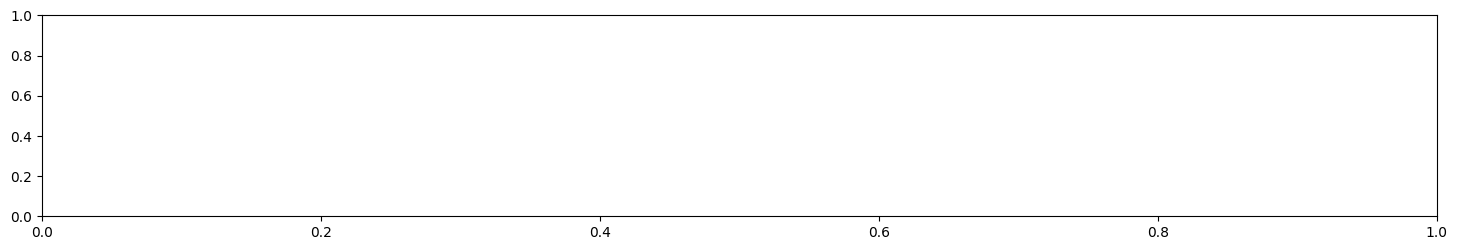

In [13]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data[-8760:]['timestamp'], data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries[IQR_results].index, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data[-8760:]['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

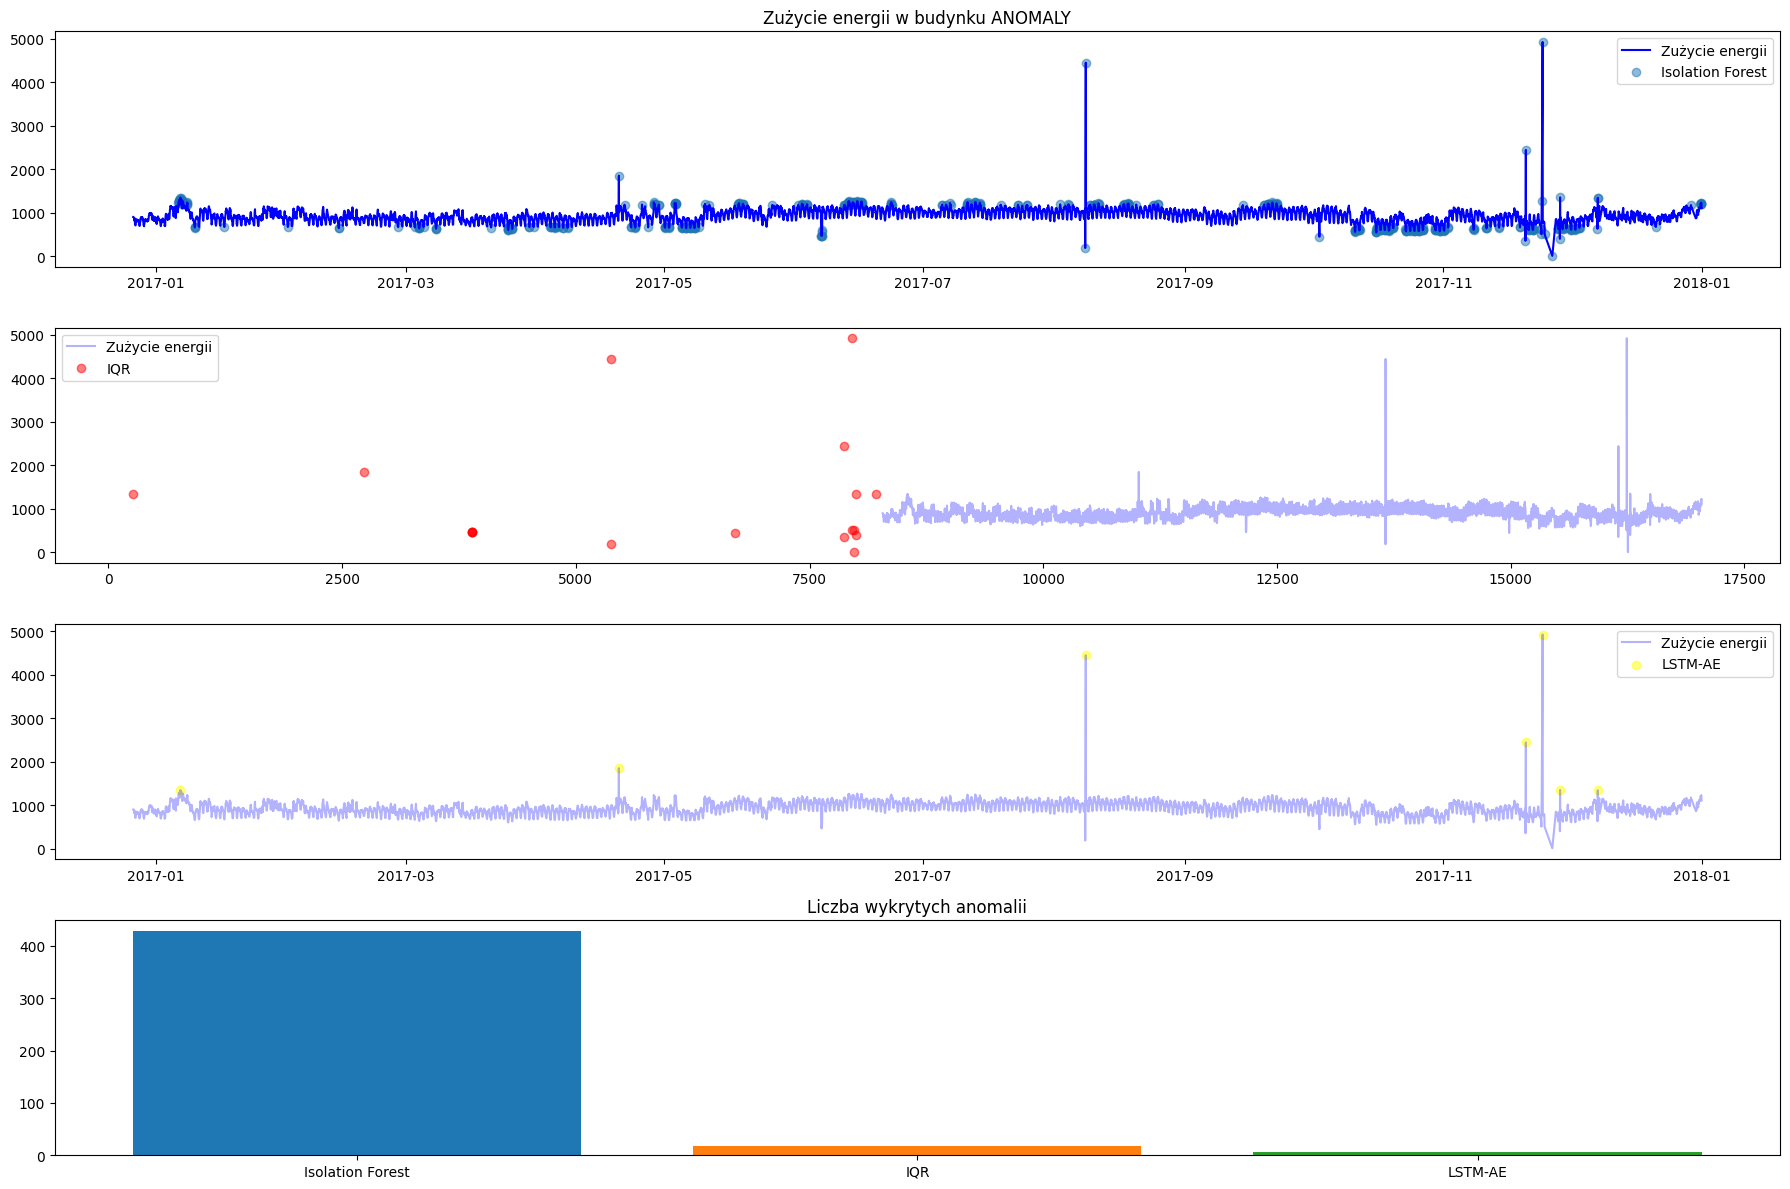

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

In [ ]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========


NameError: name 'timeseries' is not defined

--- ANOMALY 1

Liczba anomalii wykrytych przez IQR: 24/39\
Liczba anomalii wykrytych przez IQR spoza zakresu: 9\
Liczba anomalii wykrytych przez IF: 39/39\
Liczba anomalii wykrytych przez IF spoza zakresu: 131\
Liczba anomalii wykrytych przez LSTM-AE: 36/39\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 439

--- ANOMALY 2

Liczba anomalii wykrytych przez IQR: 20/51\
Liczba anomalii wykrytych przez IQR spoza zakresu: 0\
Liczba anomalii wykrytych przez IF: 51/51\
Liczba anomalii wykrytych przez IF spoza zakresu: 70\
Liczba anomalii wykrytych przez LSTM-AE: 49/51\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 579

--- ANOMALY 3

Liczba anomalii wykrytych przez IQR: 38/62\
Liczba anomalii wykrytych przez IQR spoza zakresu: 8\
Liczba anomalii wykrytych przez IF: 62/62\
Liczba anomalii wykrytych przez IF spoza zakresu: 54\
Liczba anomalii wykrytych przez LSTM-AE: 49/62\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 796

### Wyniki dla ostatniego roku
=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 39/39
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 39/39
Liczba anomalii wykrytych przez IF spoza zakresu: 799
Liczba anomalii wykrytych przez LSTM-AE: 4/39
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 3
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/51
Liczba anomalii wykrytych przez IQR spoza zakresu: 17
Liczba anomalii wykrytych przez IF: 51/51
Liczba anomalii wykrytych przez IF spoza zakresu: 552
Liczba anomalii wykrytych przez LSTM-AE: 24/51
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 7
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 330
Liczba anomalii wykrytych przez LSTM-AE: 29/62
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 88




In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

data = [
    ("IQR", "I", 34, 5, 132, 16871),
    ("IQR", "II", 30, 21, 10, 11999),
    ("IQR", "III", 50, 12, 40, 7721),
    ("IF z percentylem 0.95", "I", 39, 0, 802, 16201),
    ("IF z percentylem 0.95", "II", 51, 0, 549, 11460),
    ("IF z percentylem 0.95", "III", 62, 0, 330, 7431),

    ("IF z IQR", "I", 38, 1, 3, 12018),
    ("IF z IQR", "II", 44, 7, 17, 11992),
    ("IF z IQR", "III", 62, 0, 85, 7676),
    
    ("LSTM-AE", "I", 38, 1, 761, 16242),
    ("LSTM-AE", "II", 50, 1, 819, 11190),
    ("LSTM-AE", "III", 49, 13, 769, 6992),
]

df = pd.DataFrame(data, columns=["Model", "Budynek", "TP", "FN", "FP", "TN"])

df["Precision"] = df["TP"] / (df["TP"] + df["FP"])
df["Recall"] = df["TP"] / (df["TP"] + df["FN"])
df["F1-score"] = 2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])
df["Accuracy"] = (df["TP"] + df["TN"]) / (df["TP"] + df["TN"] + df["FP"] + df["FN"])

df_metrics_1 = df[["Model", "Budynek", "Precision", "Recall", "F1-score", "Accuracy"]].round(4)
df_metrics_1

,Model,Budynek,Precision,Recall,F1-score,Accuracy
0,IQR,I,0.2048,0.8718,0.3317,0.9920
1,IQR,II,0.7500,0.5882,0.6593,0.9974
2,IQR,III,0.5556,0.8065,0.6579,0.9934
3,IF z percentylem 0.95,I,0.0464,1.0000,0.0886,0.9529
4,IF z percentylem 0.95,II,0.0850,1.0000,0.1567,0.9545
5,IF z percentylem 0.95,III,0.1582,1.0000,0.2731,0.9578
6,IF z IQR,I,0.9268,0.9744,0.9500,0.9997
7,IF z IQR,II,0.7213,0.8627,0.7857,0.9980
8,IF z IQR,III,0.4218,1.0000,0.5933,0.9891
9,LSTM-AE,I,0.0476,0.9744,0.0907,0.9553


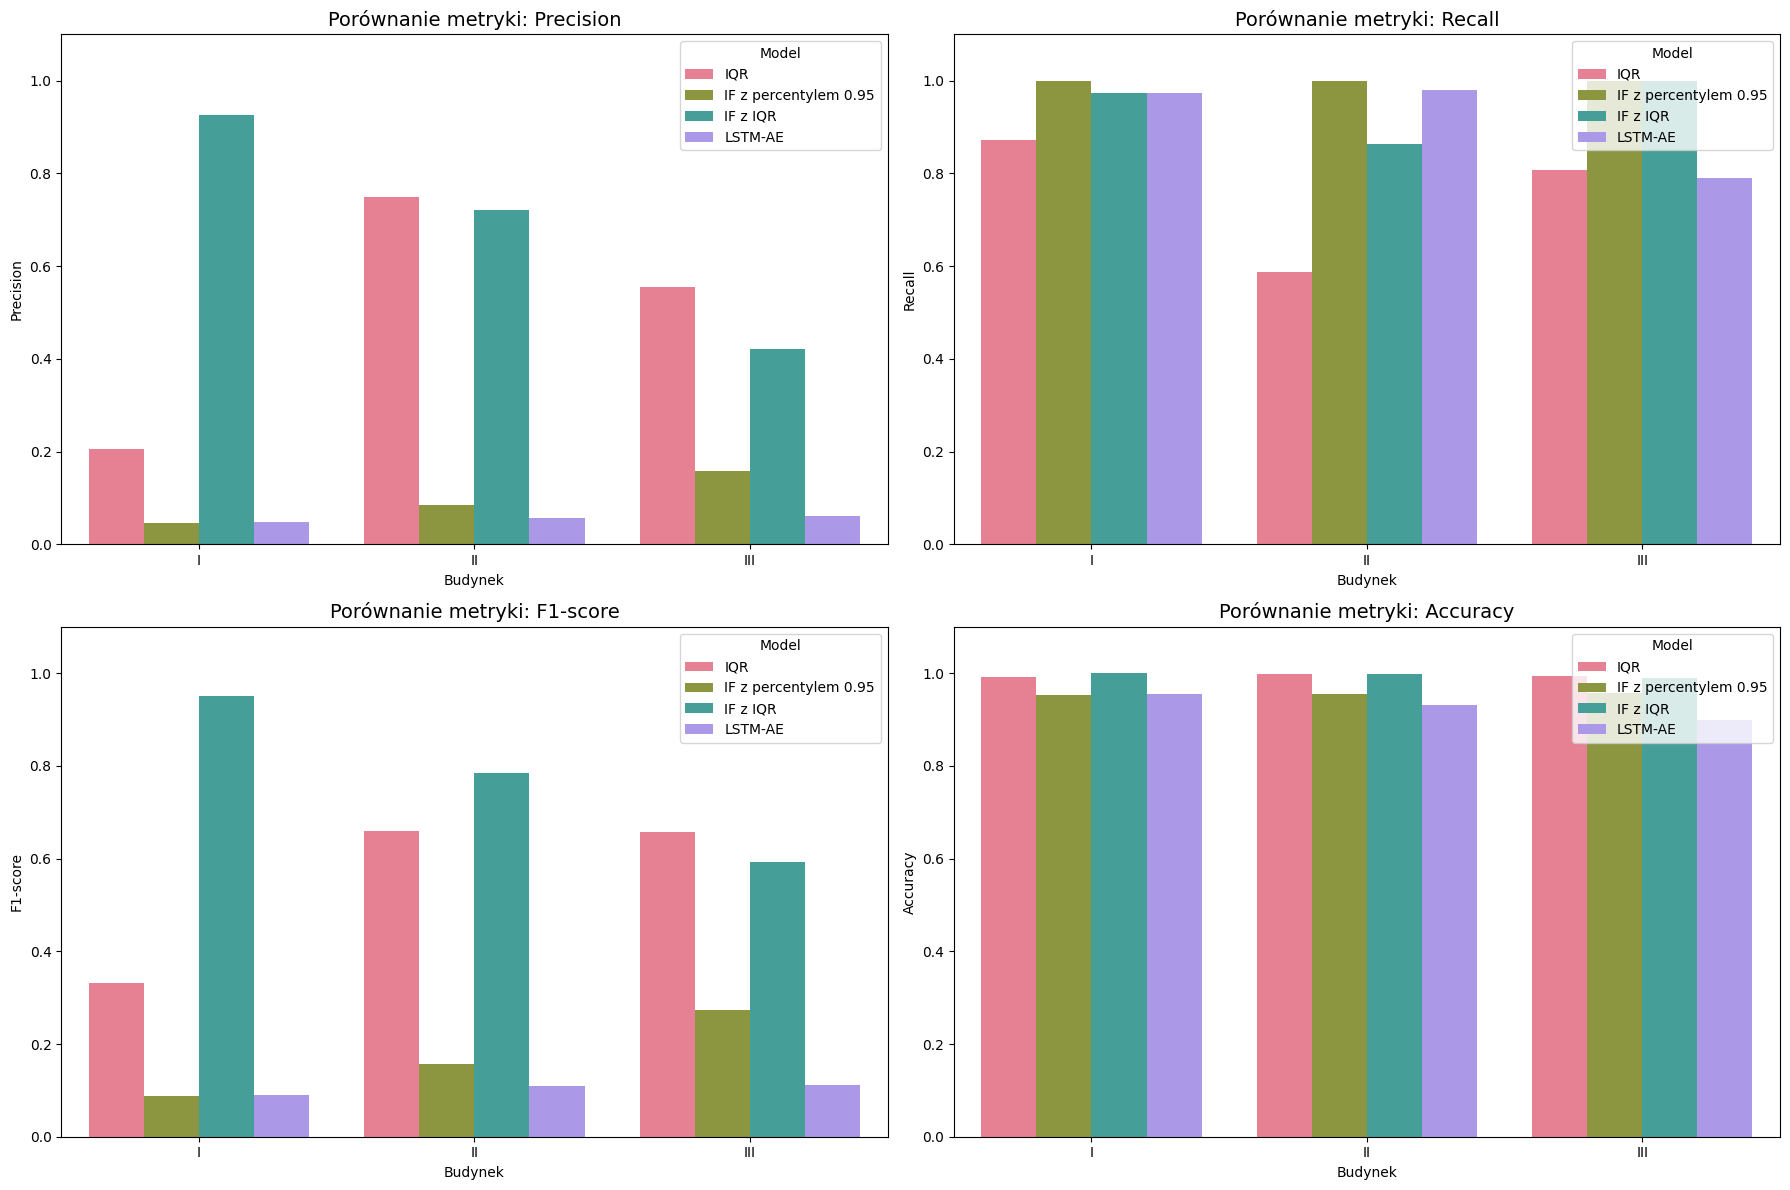

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.DataFrame(df_metrics_1, columns=['Model', 'Budynek', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
df1['Tabela'] = 'Tabela 1'

metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
unique_models = df1['Model'].unique()
palette = sns.color_palette("husl", len(unique_models))
model_colors = dict(zip(unique_models, palette))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    df_sorted = df1.copy()
    df_sorted['sort_key'] = df_sorted.groupby('Budynek')[metric].rank(ascending=False, method='first')
    df_sorted = df_sorted.sort_values(by=['Budynek', 'sort_key'])
    df_sorted.reset_index(drop=True, inplace=True)
    
    sns.barplot(
        data=df_sorted,
        x='Budynek',
        y=metric,
        hue='Model',
        ax=ax,
        errorbar=None,
        dodge=True,
        palette=model_colors,
        hue_order=unique_models
    )
    
    ax.set_title(f'Porównanie metryki: {metric}', fontsize=14)
    ax.set_ylabel(metric)
    ax.set_xlabel('Budynek')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Model')

plt.tight_layout()
plt.show()

### Z oknami, ROK

In [41]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseriesW[IQR_resultsW].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseriesW[IQR_resultsW].index)) - c}")

c = 0

for i in list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2W[IQR_results2W].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2W[IQR_results2W].index)) - c}")

c = 0

for i in list(IF_results2W[IF_results2W['isolation_forest'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2W[IF_results2W['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3W[IQR_results3W].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3W[IQR_results3W].index)) - c}")

c = 0

for i in list(IF_results3W[IF_results3W['isolation_forest'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3W[IF_results3W['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 0/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 81
Liczba anomalii wykrytych przez IF: 0/16
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM-AE: 15/16
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 592
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 0/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 34
Liczba anomalii wykrytych przez IF: 7/47
Liczba anomalii wykrytych przez IF spoza zakresu: 28
Liczba anomalii wykrytych przez LSTM-AE: 45/47
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 388
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 50/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 40
Liczba anomalii wykrytych przez IF: 2/62
Liczba anomalii wykrytych przez IF spoza zakresu: 136
Liczba anomalii wykrytych przez LSTM-AE: 55/62
Liczba anomalii wykrytych przez LSTM-AE spoza 

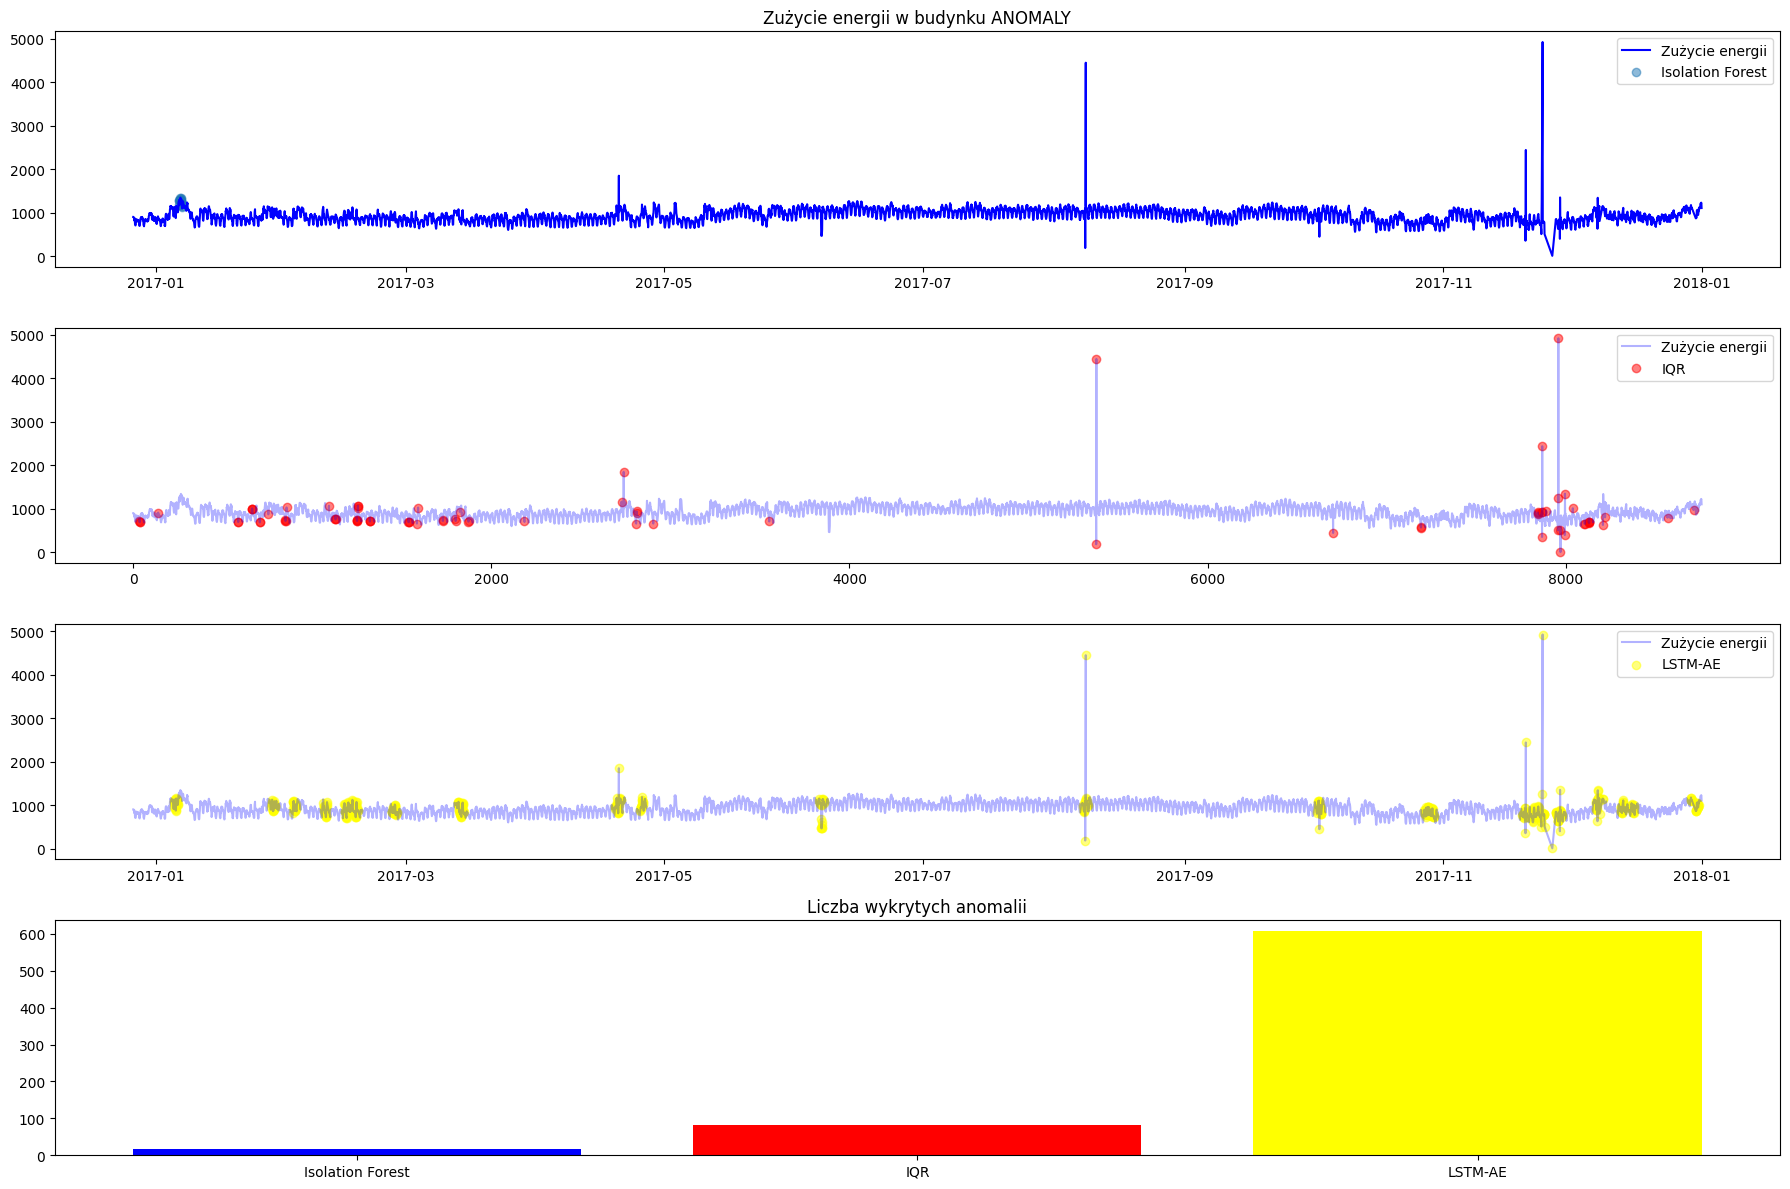

In [43]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IFW = IF_resultsW[IF_resultsW['isolation_forest'] == 1].count()
counts_IQRW = timeseriesW[IQR_resultsW].count()
counts_LSTMW = LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IFW,color='blue')
plt.bar('IQR', counts_IQRW, color='red')
plt.bar('LSTM-AE', counts_LSTMW, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

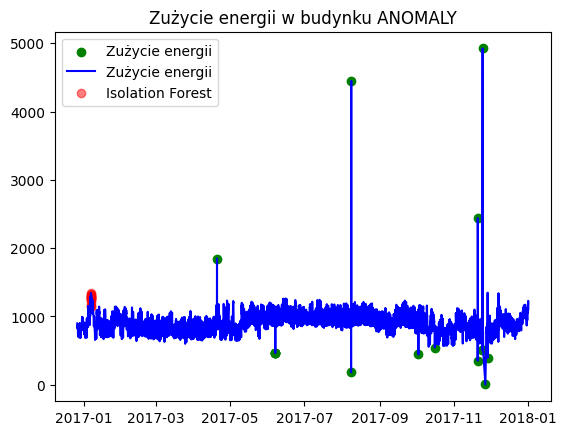

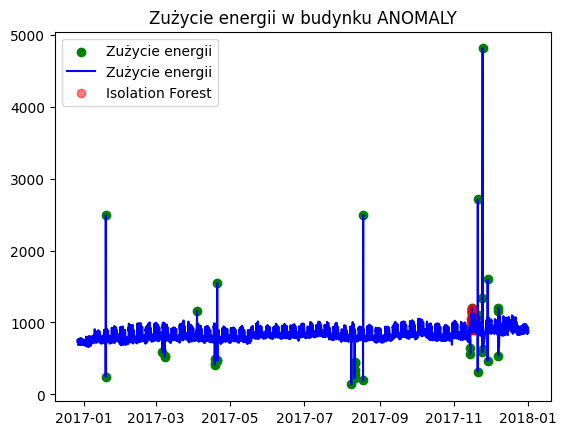

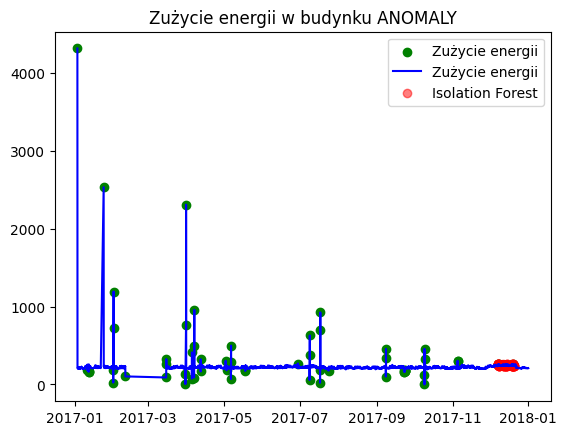

In [56]:
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2W['timestamp'][IF_results2W['isolation_forest'] == 1], IF_results2W['energy_consumption'][IF_results2W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3W['timestamp'][IF_results3W['isolation_forest'] == 1], IF_results3W['energy_consumption'][IF_results3W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


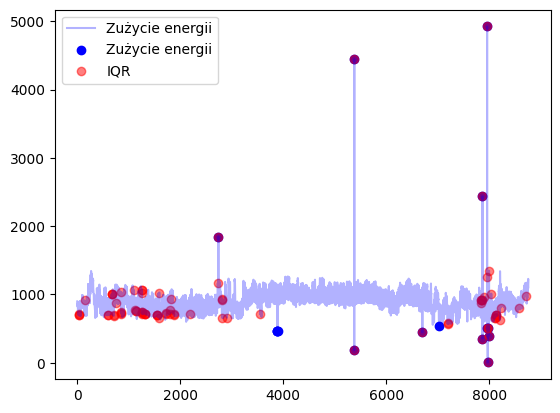

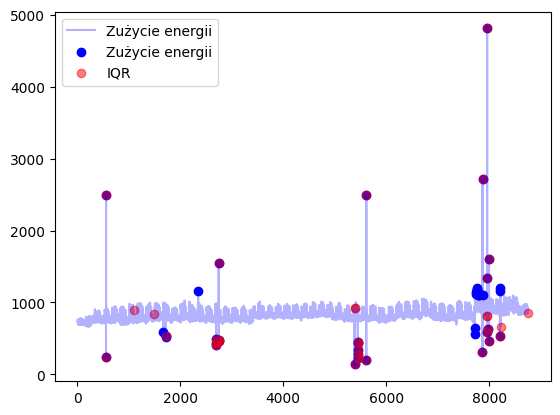

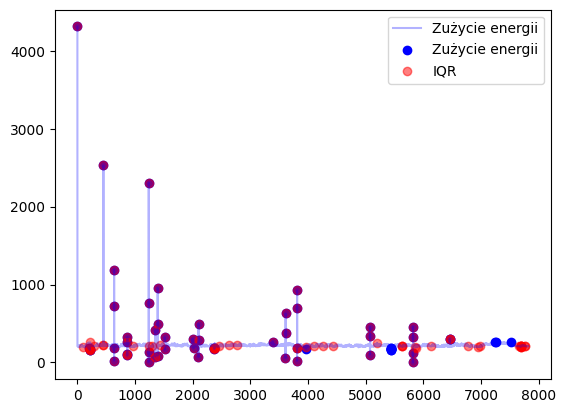

In [90]:
temp = dataW.reset_index().drop(columns=['index'])
temp2 = data2W.reset_index().drop(columns=['index'])
temp3 = data3W.reset_index().drop(columns=['index'])

plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp[temp['anomaly'] == True].index, temp[temp['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2[temp2['anomaly'] == True].index, temp2[temp2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2W[IQR_results2W].index, timeseries2W[IQR_results2W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3[temp3['anomaly'] == True].index, temp3[temp3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3W[IQR_results3W].index, timeseries3W[IQR_results3W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



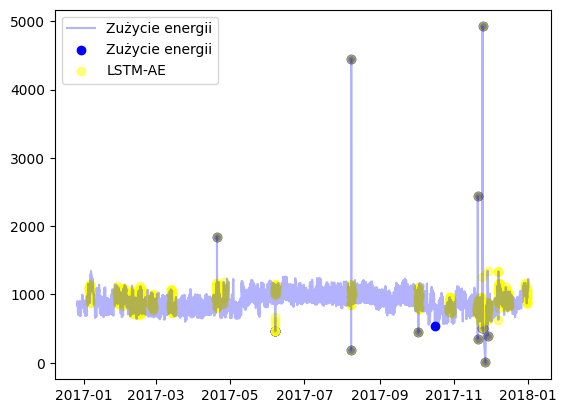

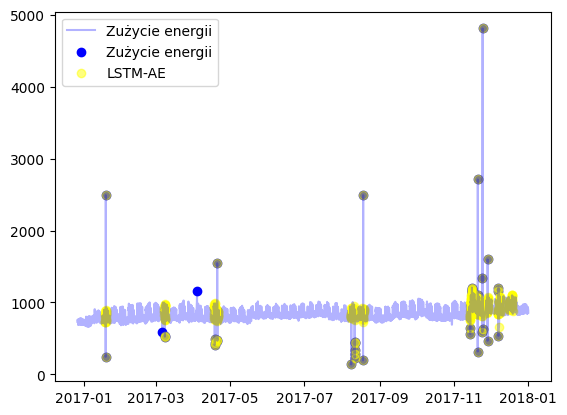

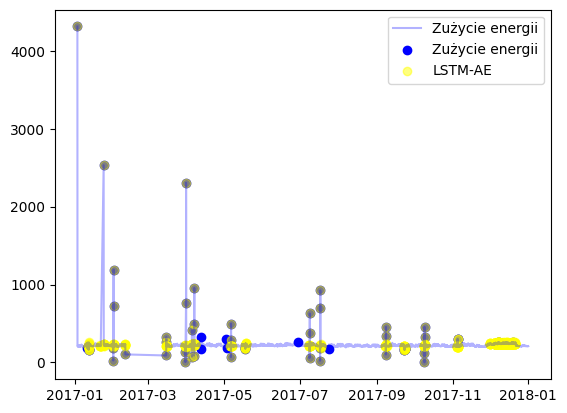

In [65]:

plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results2W['timestamp'][LSTM_results2W['lstm_autoencoder'] == 1], LSTM_results2W['energy_consumption'][LSTM_results2W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results3W['timestamp'][LSTM_results3W['lstm_autoencoder'] == 1], LSTM_results3W['energy_consumption'][LSTM_results3W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

### Bez okien, ROK

In [103]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
# LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

In [104]:
data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
#LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
#LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

In [105]:
tempN = data.reset_index().drop(columns=['index'])
temp2N = data2.reset_index().drop(columns=['index'])
temp3N = data3.reset_index().drop(columns=['index'])

print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(tempN[tempN['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
#     if i in list(data[data['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(temp2N[temp2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
#     if i in list(data2[data2['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(temp3N[temp3N['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


# for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
#     if i in list(data3[data3['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 15/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 16/16
Liczba anomalii wykrytych przez IF spoza zakresu: 403
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 7
Liczba anomalii wykrytych przez IF: 47/47
Liczba anomalii wykrytych przez IF spoza zakresu: 389
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 329


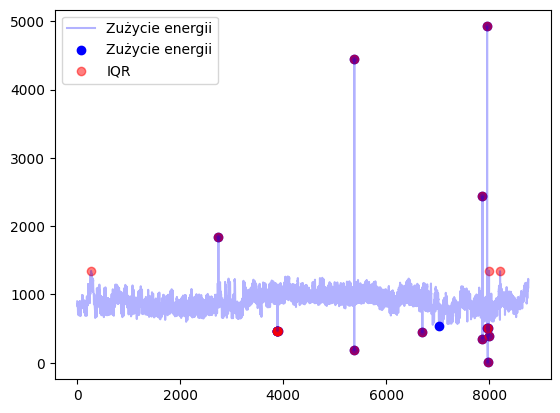

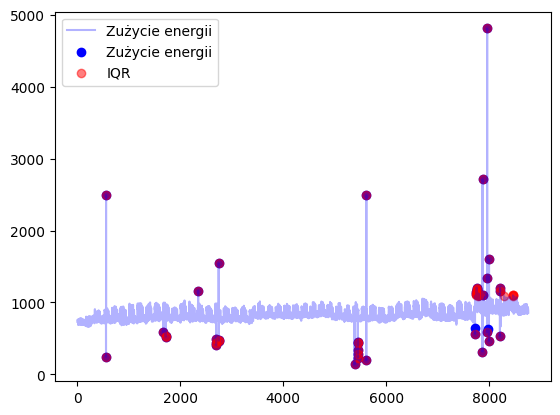

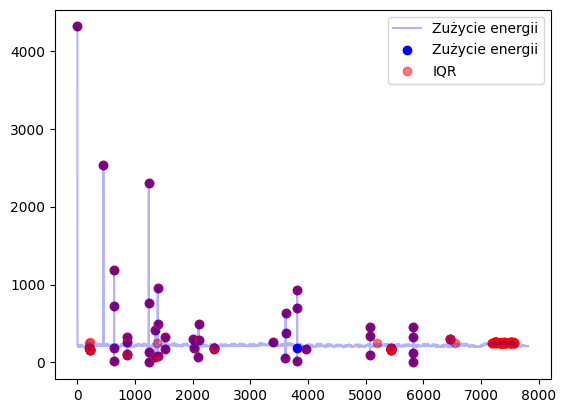

In [106]:
plt.plot(timeseries, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(tempN[tempN['anomaly'] == True].index, tempN[tempN['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_results].index, timeseriesW[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2N[temp2N['anomaly'] == True].index, temp2N[temp2N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2[IQR_results2].index, timeseries2[IQR_results2], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3N[temp3N['anomaly'] == True].index, temp3N[temp3N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3[IQR_results3].index, timeseries3[IQR_results3], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



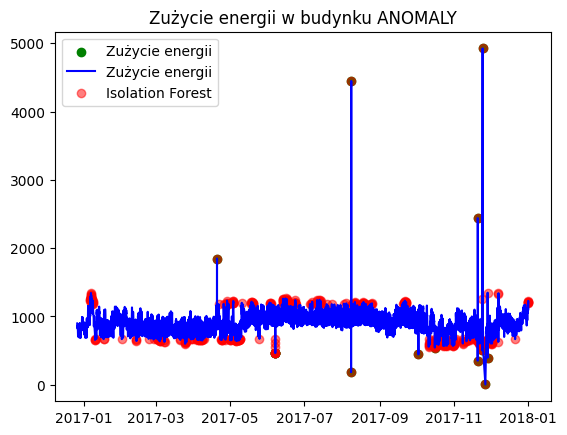

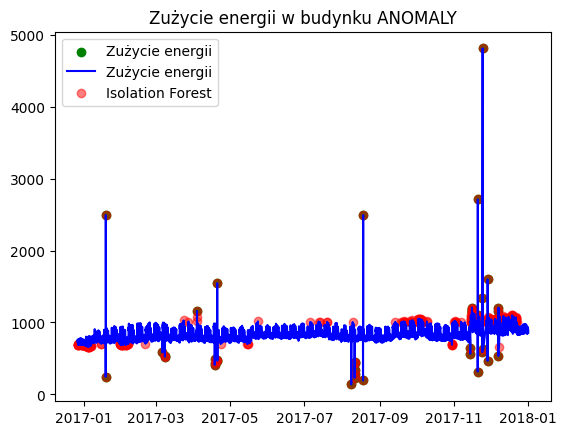

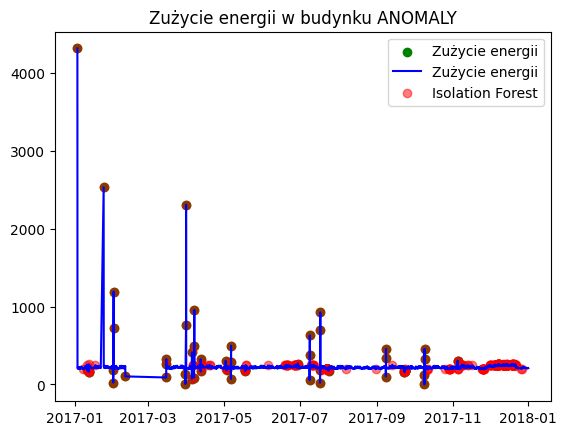

In [107]:
plt.scatter(data[data['anomaly'] == True]['timestamp'], data[data['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2[data2['anomaly'] == True]['timestamp'], data2[data2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2['timestamp'], data2['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2['timestamp'][IF_results2['isolation_forest'] == 1], IF_results2['energy_consumption'][IF_results2['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3[data3['anomaly'] == True]['timestamp'], data3[data3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3['timestamp'], data3['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3['timestamp'][IF_results3['isolation_forest'] == 1], IF_results3['energy_consumption'][IF_results3['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


### WYBÓR MODELI

In [446]:
d = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
d = d.set_index("timestamp")
d_lstm = d
resIF = isolation_forest_IQR(data=d)
resLSTM = lstm_autoencoder(d_lstm, window_size=24, iqr_multiplier=4.5)
t, resIQR = dynamic_iqr(d['energy_consumption'], w=None, k=1.5)

d2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
d2 = d2.set_index("timestamp")
d_lstm2 = d2
resIF2 = isolation_forest_IQR(data=d2)
resLSTM2 = lstm_autoencoder(d_lstm2, window_size=24, iqr_multiplier=4.5)
t2, resIQR2 = dynamic_iqr(d2['energy_consumption'], w=None, k=1.5)

d3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
d3 = d3.set_index("timestamp")
d_lstm3 = d3
resIF3 = isolation_forest_IQR(data=d3)
resLSTM3 = lstm_autoencoder(d_lstm3, window_size=24, iqr_multiplier=4.5)
t3, resIQR3 = dynamic_iqr(d3['energy_consumption'], w=None, k=1.5)

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 2.9822e-04 - mae: 0.0114 - val_loss: 5.2022e-04 - val_mae: 0.0087
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.5607e-04 - mae: 0.0075 - val_loss: 5.0783e-04 - val_mae: 0.0086
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 1.3185e-04 - mae: 0.0071 - val_loss: 5.1062e-04 - val_mae: 0.0087
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 1.4165e-04 - mae: 0.0068 - val_loss: 4.9195e-04 - val_mae: 0.0084
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.4005e-04 - mae: 0.0067 - val_loss: 4.8373e-04 - val_mae: 0.0084
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.3201e-04 - mae: 0.0065 - val_loss: 4.7934e-04 - val_mae: 0.0085
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.2948e-04 - mae: 0.0065 - val_loss: 4.8693e-04 - val_mae: 0.0084
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.3993e-04 - mae: 0.0065 - val_loss: 4.6354e-04

c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 8.7623e-05 - mae: 0.0050 - val_loss: 4.4513e-04 - val_mae: 0.0053
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.3386e-05 - mae: 0.0040 - val_loss: 4.4508e-04 - val_mae: 0.0048
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.2786e-05 - mae: 0.0039 - val_loss: 4.6551e-04 - val_mae: 0.0050
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.7171e-05 - mae: 0.0037 - val_loss: 4.7050e-04 - val_mae: 0.0050
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 8.8682e-05 - mae: 0.0038 - val_loss: 4.7405e-04 - val_mae: 0.0051
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.2699e-05 - mae: 0.0037 - val_loss: 4.7100e-04 - val_mae: 0.0050
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 6.9718e-05 - mae: 0.0036 - val_loss: 5.0070e-04 - val_mae: 0.0051
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.8267e-05 - mae: 0.0035 - val_loss: 4.9326e-04 -

c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 2.3069e-04 - mae: 0.0082 - val_loss: 1.0744e-05 - val_mae: 0.0027
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.0373e-04 - mae: 0.0035 - val_loss: 4.5390e-06 - val_mae: 0.0016
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.0752e-04 - mae: 0.0029 - val_loss: 3.0310e-06 - val_mae: 0.0013
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 8.5727e-05 - mae: 0.0024 - val_loss: 3.0847e-06 - val_mae: 0.0014
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 9.0865e-05 - mae: 0.0023 - val_loss: 3.1352e-06 - val_mae: 0.0014
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.1010e-04 - mae: 0.0024 - val_loss: 3.0528e-06 - val_mae: 0.0013
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 9.0993e-05 - mae: 0.0021 - val_loss: 3.5708e-06 - val_mae: 0.0014
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 9.1882e-05 - mae: 0.0021 - val_loss: 8.9542e-06 - val_mae: 0

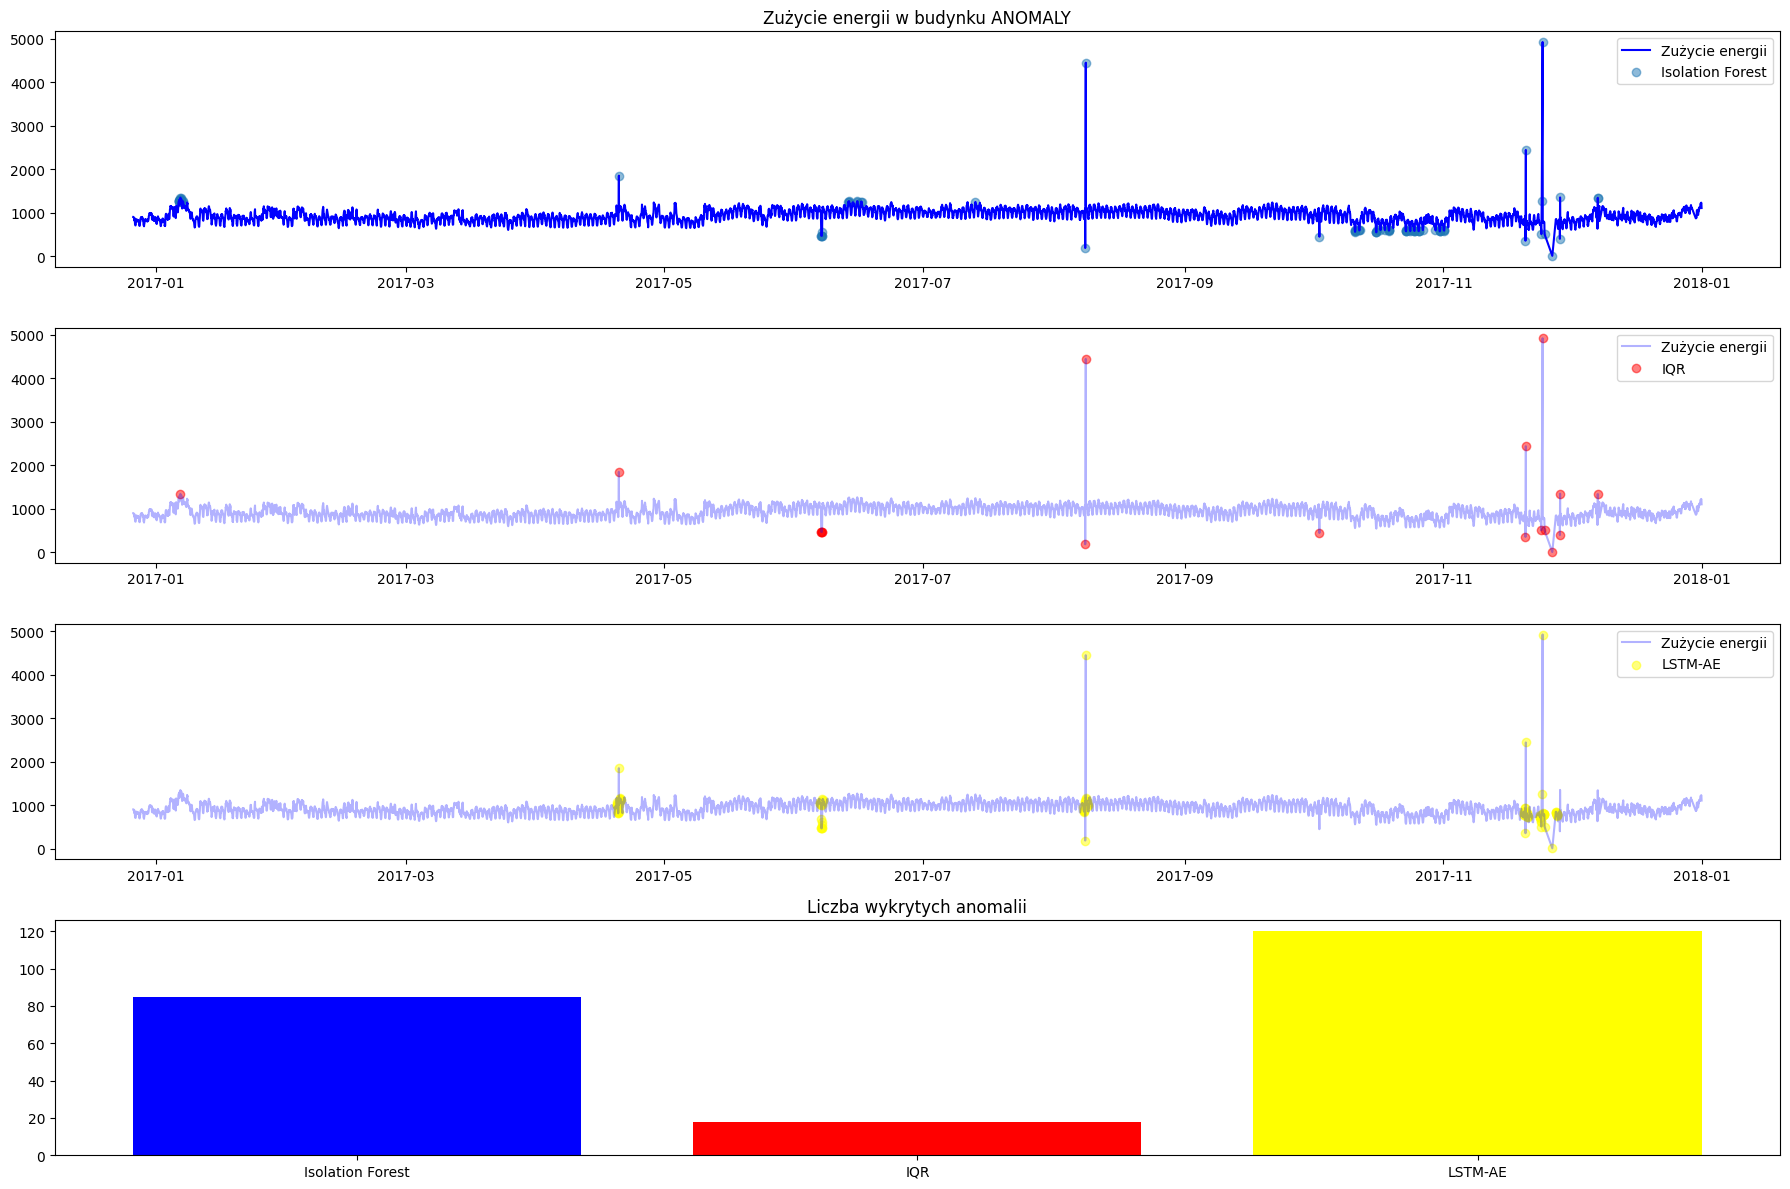

In [441]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d.index, d['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF.index[resIF['isolation_forest'] == 1], resIF['energy_consumption'][resIF['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t[resIQR].index, t[resIQR], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d.index, d['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM['timestamp'][resLSTM['lstm_autoencoder'] == 1], resLSTM['energy_consumption'][resLSTM['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = resIF[resIF['isolation_forest'] == 1].count()
counts_IQR = t[resIQR].count()
counts_LSTM = resLSTM[resLSTM['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF,color='blue')
plt.bar('IQR', counts_IQR, color='red')
plt.bar('LSTM-AE', counts_LSTM, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

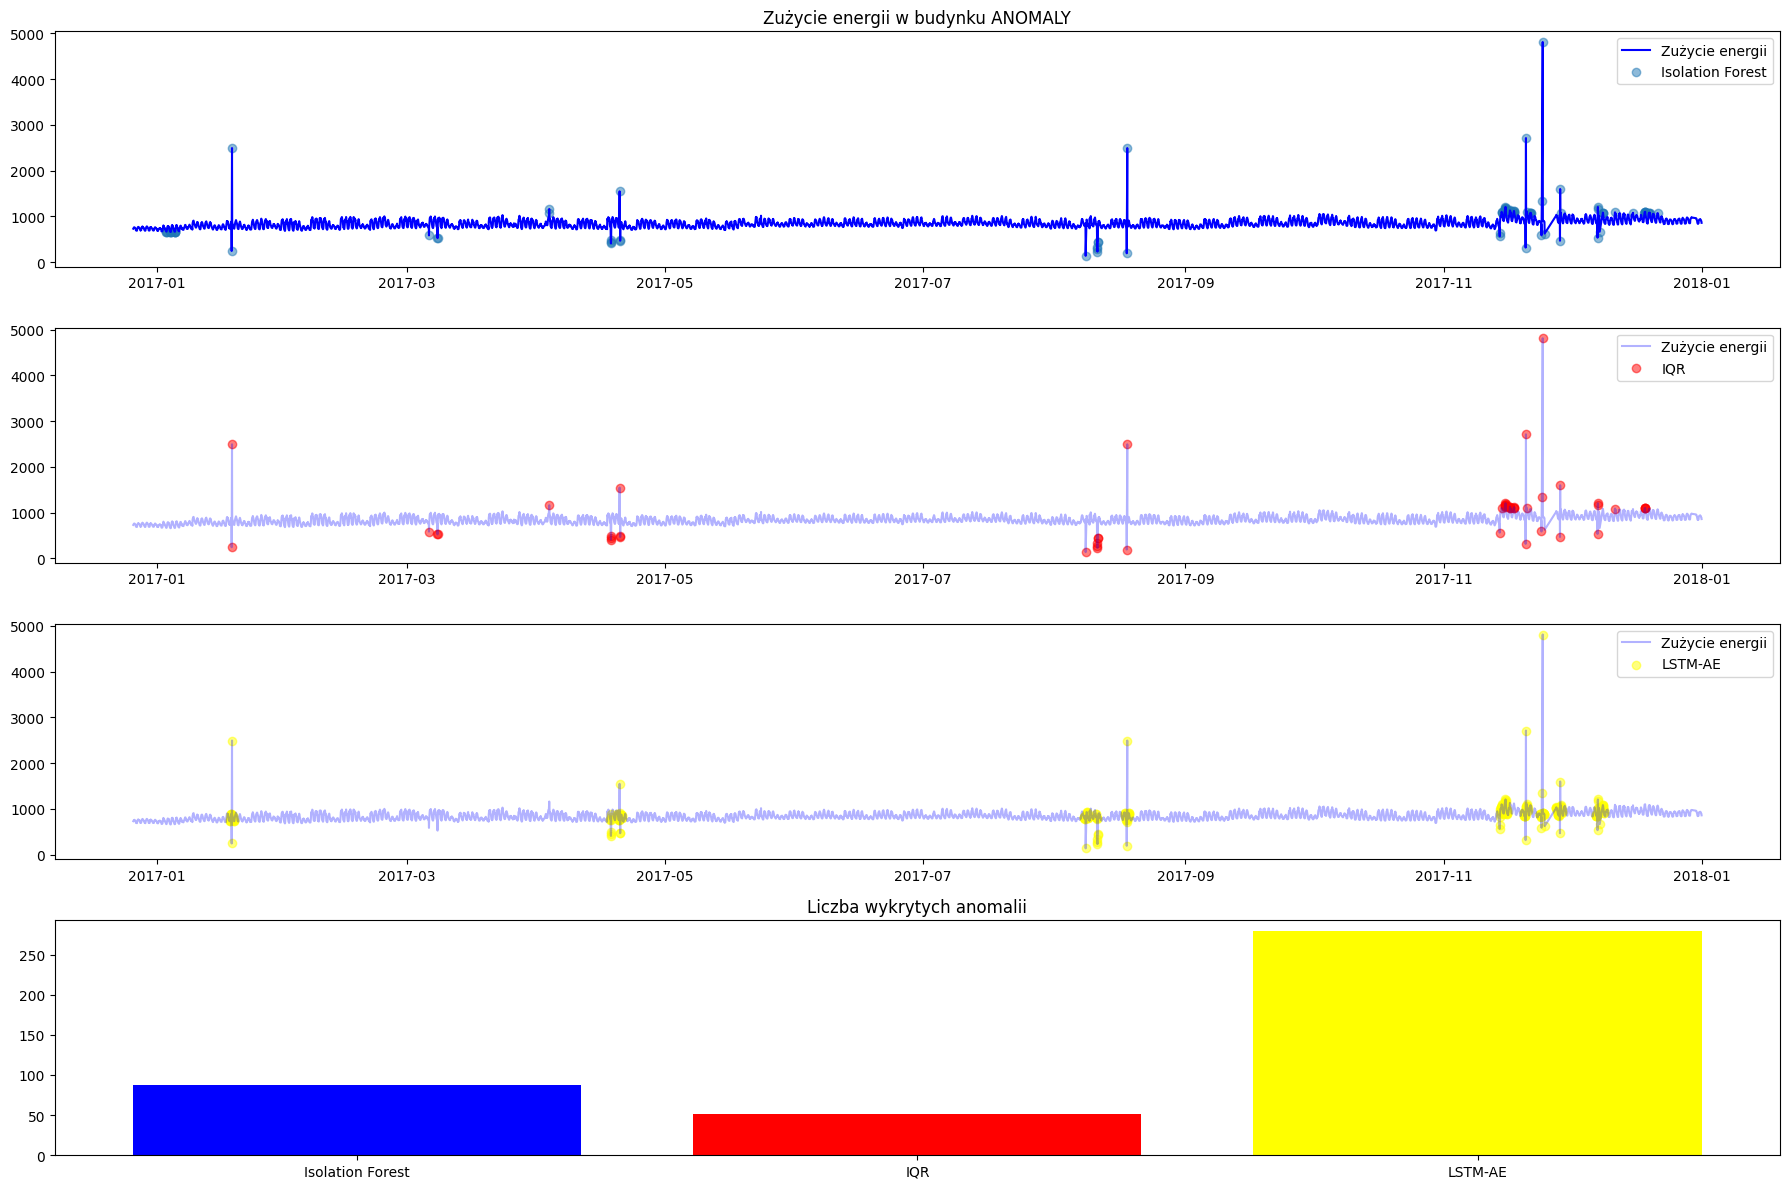

In [442]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d2.index, d2['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF2.index[resIF2['isolation_forest'] == 1], resIF2['energy_consumption'][resIF2['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t2, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t2[resIQR2].index, t2[resIQR2], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d2.index, d2['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM2['timestamp'][resLSTM2['lstm_autoencoder'] == 1], resLSTM2['energy_consumption'][resLSTM2['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF2 = resIF2[resIF2['isolation_forest'] == 1].count()
counts_IQR2 = t2[resIQR2].count()
counts_LSTM2 = resLSTM2[resLSTM2['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF2,color='blue')
plt.bar('IQR', counts_IQR2, color='red')
plt.bar('LSTM-AE', counts_LSTM2, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()

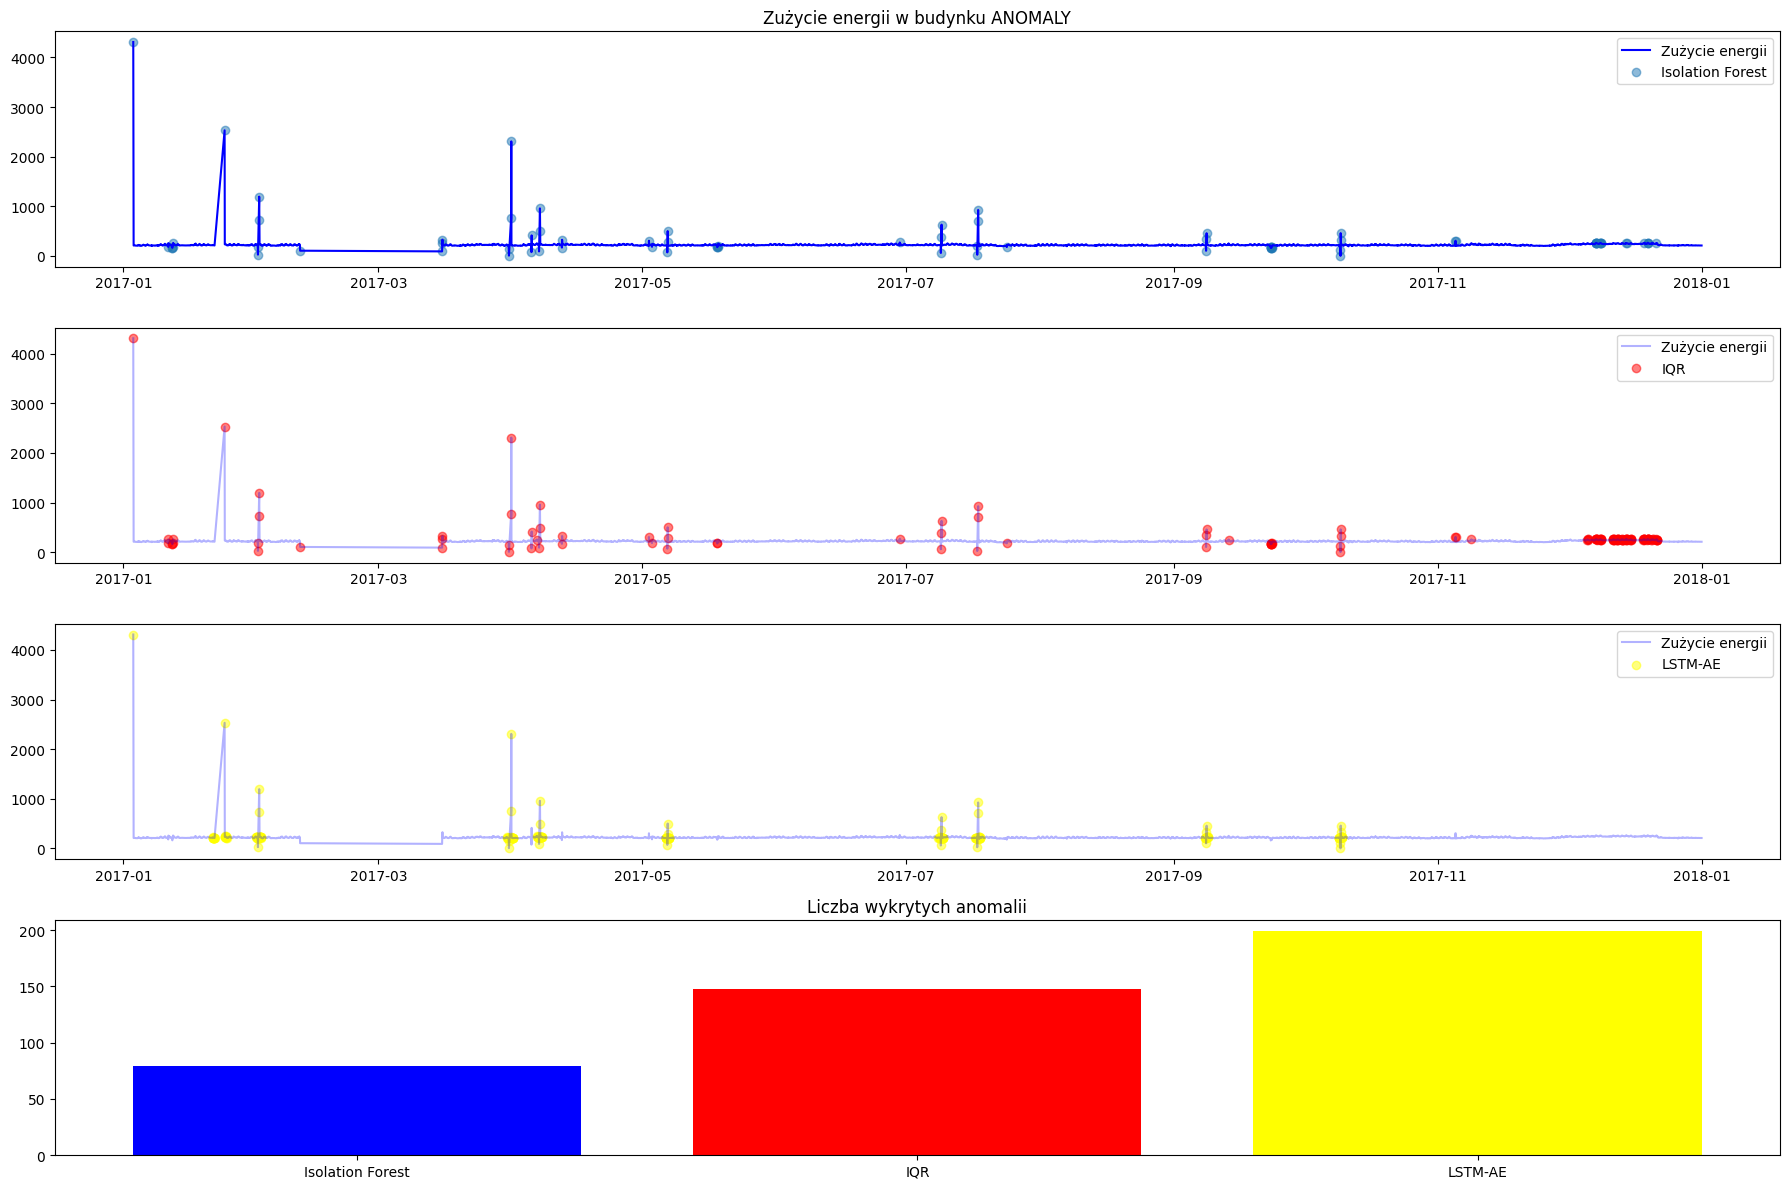

In [443]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d3.index, d3['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF3.index[resIF3['isolation_forest'] == 1], resIF3['energy_consumption'][resIF3['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t3, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t3[resIQR3].index, t3[resIQR3], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d3.index, d3['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM3['timestamp'][resLSTM3['lstm_autoencoder'] == 1], resLSTM3['energy_consumption'][resLSTM3['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF3 = resIF3[resIF3['isolation_forest'] == 1].count()
counts_IQR3 = t3[resIQR3].count()
counts_LSTM3 = resLSTM3[resLSTM3['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF3,color='blue')
plt.bar('IQR', counts_IQR3, color='red')
plt.bar('LSTM-AE', counts_LSTM3, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()

In [447]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(t[resIQR].index):
    if i in list(d[d['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t[resIQR].index)) - c}")

c = 0

for i in list(resIF[resIF['isolation_forest'] == 1].index):
    if i in list(d[d['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF[resIF['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM[resLSTM['lstm_autoencoder'] == 1].index):
    if i in list(d[d['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM[resLSTM['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(t2[resIQR2].index):
    if i in list(d2[d2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t2[resIQR2].index)) - c}")

c = 0

for i in list(resIF2[resIF2['isolation_forest'] == 1].index):
    if i in list(d2[d2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF2[resIF2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM2[resLSTM2['lstm_autoencoder'] == 1].index):
    if i in list(d2[d2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM2[resLSTM2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(t3[resIQR3].index):
    if i in list(d3[d3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t3[resIQR3].index)) - c}")

c = 0

for i in list(resIF3[resIF3['isolation_forest'] == 1].index):
    if i in list(d3[d3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF3[resIF3['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM3[resLSTM3['lstm_autoencoder'] == 1].index):
    if i in list(d3[d3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM3[resLSTM3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 15/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 16/16
Liczba anomalii wykrytych przez IF spoza zakresu: 67
Liczba anomalii wykrytych przez LSTM-AE: 13/16
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 106
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 7
Liczba anomalii wykrytych przez IF: 47/47
Liczba anomalii wykrytych przez IF spoza zakresu: 41
Liczba anomalii wykrytych przez LSTM-AE: 33/47
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 230
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM-AE: 38/62
Liczba anomalii wykrytych przez LSTM-AE spoz

In [474]:
import pandas as pd

def calculate_metrics(y_true, y_pred):
    TP = ((y_true == True) & (y_pred == True)).sum()
    FP = ((y_true == False) & (y_pred == True)).sum()
    TN = ((y_true == False) & (y_pred == False)).sum()
    FN = ((y_true == True) & (y_pred == False)).sum()
    
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1_score
    }

def evaluate_method(true_anomalies, predicted_anomalies):
    common_index = true_anomalies.index.intersection(predicted_anomalies.index)
    y_true = true_anomalies.loc[common_index]
    y_pred = predicted_anomalies.loc[common_index]
    return calculate_metrics(y_true, y_pred)

results = []

true_anomalies_b1 = d['anomaly']
tp_b1 = d['anomaly']

iqr_pred_b1 = pd.Series(False, index=tp_b1.index)
common_idx = iqr_pred_b1.index.intersection(t[resIQR].index)
iqr_pred_b1.loc[common_idx] = True
metrics_iqr_b1 = evaluate_method(tp_b1, iqr_pred_b1)
metrics_iqr_b1.update({'Metoda': 'IQR'})
results.append(metrics_iqr_b1)

if_pred_b1 = pd.Series(False, index=true_anomalies_b1.index)
if_pred_b1.loc[resIF.index] = (resIF['isolation_forest'] == 1)
metrics_if_b1 = evaluate_method(true_anomalies_b1, if_pred_b1)
metrics_if_b1.update({'Metoda': 'Isolation Forest'})
results.append(metrics_if_b1)

lstm_pred_b1 = pd.Series(False, index=true_anomalies_b1.index)
lstm_pred_b1.loc[resLSTM.index] = (resLSTM['lstm_autoencoder'] == 1)
metrics_lstm_b1 = evaluate_method(true_anomalies_b1, lstm_pred_b1)
metrics_lstm_b1.update({'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b1)

true_anomalies_b2 = d2['anomaly']
tp_b2 = d2['anomaly']

iqr_pred_b2 = pd.Series(False, index=tp_b2.index)
common_idx = iqr_pred_b2.index.intersection(t2[resIQR2].index)
iqr_pred_b2.loc[common_idx] = True
metrics_iqr_b2 = evaluate_method(tp_b2, iqr_pred_b2)
metrics_iqr_b2.update({'Metoda': 'IQR'})
results.append(metrics_iqr_b2)

if_pred_b2 = pd.Series(False, index=true_anomalies_b2.index)
if_pred_b2.loc[resIF2.index] = (resIF2['isolation_forest'] == 1)
metrics_if_b2 = evaluate_method(true_anomalies_b2, if_pred_b2)
metrics_if_b2.update({'Metoda': 'Isolation Forest'})
results.append(metrics_if_b2)

lstm_pred_b2 = pd.Series(False, index=true_anomalies_b2.index)
lstm_pred_b2.loc[resLSTM2.index] = (resLSTM2['lstm_autoencoder'] == 1)
metrics_lstm_b2 = evaluate_method(true_anomalies_b2, lstm_pred_b2)
metrics_lstm_b2.update({'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b2)

true_anomalies_b3 = d3['anomaly']
tp_b3 = d3['anomaly']

iqr_pred_b3 = pd.Series(False, index=tp_b3.index)
common_idx = iqr_pred_b3.index.intersection(t3[resIQR3].index)
iqr_pred_b3.loc[common_idx] = True
metrics_iqr_b3 = evaluate_method(tp_b3, iqr_pred_b3)
metrics_iqr_b3.update({'Metoda': 'IQR'})
results.append(metrics_iqr_b3)

if_pred_b3 = pd.Series(False, index=true_anomalies_b3.index)
if_pred_b3.loc[resIF3.index] = (resIF3['isolation_forest'] == 1)
metrics_if_b3 = evaluate_method(true_anomalies_b3, if_pred_b3)
metrics_if_b3.update({'Metoda': 'Isolation Forest'})
results.append(metrics_if_b3)

lstm_pred_b3 = pd.Series(False, index=true_anomalies_b3.index)
lstm_pred_b3.loc[resLSTM3.index] = (resLSTM3['lstm_autoencoder'] == 1)
metrics_lstm_b3 = evaluate_method(true_anomalies_b3, lstm_pred_b3)
metrics_lstm_b3.update({'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b3)

results_df = pd.DataFrame(results)
columns_order = ['Metoda', 'TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-score']
results_df = results_df[columns_order]

percent_cols = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-score']

results_df.sort_values(by=['Accuracy'])
results_df.groupby('Metoda').apply(lambda x: x.sort_values(by='Accuracy', ascending=False)).reset_index(drop=True)

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\3769392517.py:108: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_df.groupby('Metoda').apply(lambda x: x.sort_values(by='Accuracy', ascending=False)).reset_index(drop=True)


,Metoda,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1-score
0,IQR,15,3,8741,1,0.9995,0.8333,0.9375,0.9997,0.8824
1,IQR,45,7,8706,2,0.9990,0.8654,0.9574,0.9992,0.9091
2,IQR,60,88,7673,2,0.9885,0.4054,0.9677,0.9887,0.5714
3,Isolation Forest,62,17,7744,0,0.9978,0.7848,1.0000,0.9978,0.8794
4,Isolation Forest,47,41,8672,0,0.9953,0.5341,1.0000,0.9953,0.6963
5,Isolation Forest,16,67,8677,0,0.9924,0.1928,1.0000,0.9923,0.3232
6,LSTM-AE,13,106,8638,3,0.9876,0.1092,0.8125,0.9879,0.1926
7,LSTM-AE,33,230,8483,14,0.9721,0.1255,0.7021,0.9736,0.2129
8,LSTM-AE,38,235,7526,24,0.9669,0.1392,0.6129,0.9697,0.2269


In [477]:
results_df[['Accuracy','Precision','Recall','Specificity','F1-score', 'Metoda']].groupby('Metoda').describe().T

Metoda               IQR  Isolation Forest  LSTM-AE
Accuracy    count 3.0000            3.0000   3.0000
            mean  0.9957            0.9952   0.9755
            std   0.0062            0.0027   0.0107
            min   0.9885            0.9924   0.9669
            25%   0.9937            0.9938   0.9695
            50%   0.9990            0.9953   0.9721
            75%   0.9993            0.9966   0.9799
            max   0.9995            0.9978   0.9876
Precision   count 3.0000            3.0000   3.0000
            mean  0.7014            0.5039   0.1246
            std   0.2568            0.2972   0.0150
            min   0.4054            0.1928   0.1092
            25%   0.6194            0.3634   0.1174
            50%   0.8333            0.5341   0.1255
            75%   0.8494            0.6595   0.1323
            max   0.8654            0.7848   0.1392
Recall      count 3.0000            3.0000   3.0000
            mean  0.9542            1.0000   0.7092
            std   0.0154            0.0000   0.1000
            min   0.9375            1.0000   0.6129
            25%   0.9475            1.0000   0.6575
            50%   0.9574            1.0000   0.7021
            75%   0.9626            1.0000   0.7573
            max   0.9677            1.0000   0.8125
Specificity count 3.0000            3.0000   3.0000
            mean  0.9958            0.9951   0.9771
            std   0.0062            0.0027   0.0096
            min   0.9887            0.9923   0.9697
            25%   0.9939            0.9938   0.9717
            50%   0.9992            0.9953   0.9736
            75%   0.9994            0.9966   0.9807
            max   0.9997            0.9978   0.9879
F1-score    count 3.0000            3.0000   3.0000
            mean  0.7876            0.6330   0.2108
            std   0.1877            0.2835   0.0172
            min   0.5714            0.3232   0.1926
            25%   0.7269            0.5098   0.2027
            50%   0.8824            0.6963   0.2129
            75%   0.8957            0.7879   0.2199
            max   0.9091            0.8794   0.2269

In [458]:
# Funkcja do ujednolicania formatu wyników IQR
def align_iqr_results(original_data, iqr_results):
    """Dopasowuje wyniki IQR do formatu z timestamp"""
    aligned = pd.Series(False, index=original_data.index)
    if not iqr_results.empty:
        aligned.loc[iqr_results.index.intersection(original_data.index)] = True
    return aligned

# Funkcja do przypisywania etykiet zgodności metod
def assign_consensus_labels(if_res, lstm_res, iqr_res):
    # Upewnij się, że wszystkie dane mają ten sam indeks
    consensus = pd.DataFrame(index=if_res.index)
    
    # Konwersja do typu bool z zabezpieczeniem przed brakującymi wartościami
    if_res = if_res.astype(bool) if if_res is not None else pd.Series(False, index=consensus.index)
    lstm_res = lstm_res.astype(bool) if lstm_res is not None else pd.Series(False, index=consensus.index)
    iqr_res = iqr_res.astype(bool) if iqr_res is not None else pd.Series(False, index=consensus.index)
    
    consensus['low'] = if_res  # Tylko Isolation Forest
    consensus['medium'] = if_res & (lstm_res | iqr_res)  # IF + 1 inna metoda
    consensus['high'] = if_res & lstm_res & iqr_res  # Wszystkie 3 metody
    return consensus

# Funkcja do obliczania metryk
def calculate_metrics(true_labels, pred_labels):
    # Upewnij się, że etykiety mają ten sam indeks
    true_labels, pred_labels = true_labels.align(pred_labels, fill_value=False)
    return {
        'Precision': precision_score(true_labels, pred_labels, zero_division=0),
        'Recall': recall_score(true_labels, pred_labels, zero_division=0),
        'F1': f1_score(true_labels, pred_labels, zero_division=0),
        'Accuracy': accuracy_score(true_labels, pred_labels)
    }

# Przygotowanie danych - dopasowanie formatu IQR
resIQR_aligned = align_iqr_results(d, resIQR) if 'resIQR' in locals() else pd.Series(False, index=d.index)
resIQR2_aligned = align_iqr_results(d2, resIQR2) if 'resIQR2' in locals() else pd.Series(False, index=d2.index)
resIQR3_aligned = align_iqr_results(d3, resIQR3) if 'resIQR3' in locals() else pd.Series(False, index=d3.index)

# Konwersja wyników innych metod do Series z zabezpieczeniem
if_res = resIF['isolation_forest'].astype(bool) if 'resIF' in locals() and 'isolation_forest' in resIF.columns else pd.Series(False, index=d.index)
lstm_res = resLSTM['lstm_autoencoder'].astype(bool) if 'resLSTM' in locals() and 'lstm_autoencoder' in resLSTM.columns else pd.Series(False, index=d.index)

if_res2 = resIF2['isolation_forest'].astype(bool) if 'resIF2' in locals() and 'isolation_forest' in resIF2.columns else pd.Series(False, index=d2.index)
lstm_res2 = resLSTM2['lstm_autoencoder'].astype(bool) if 'resLSTM2' in locals() and 'lstm_autoencoder' in resLSTM2.columns else pd.Series(False, index=d2.index)

if_res3 = resIF3['isolation_forest'].astype(bool) if 'resIF3' in locals() and 'isolation_forest' in resIF3.columns else pd.Series(False, index=d3.index)
lstm_res3 = resLSTM3['lstm_autoencoder'].astype(bool) if 'resLSTM3' in locals() and 'lstm_autoencoder' in resLSTM3.columns else pd.Series(False, index=d3.index)

# Analiza dla każdego zbioru danych
datasets = [
    (d, if_res, lstm_res, resIQR_aligned, 'anomaly_one'),
    (d2, if_res2, lstm_res2, resIQR2_aligned, 'anomaly_two'),
    (d3, if_res3, lstm_res3, resIQR3_aligned, 'anomaly_three')
]

final_results = []

for data, if_res, lstm_res, iqr_res, name in datasets:
    try:
        # Upewnij się, że kolumna anomaly istnieje
        if 'anomaly' not in data.columns:
            raise KeyError(f"Column 'anomaly' not found in dataset {name}")
            
        # Przypisz etykiety zgodności
        consensus = assign_consensus_labels(if_res, lstm_res, iqr_res)
        
        # Prawdziwe anomalie
        true_anomalies = data['anomaly']
        
        # Oblicz metryki dla każdego poziomu pewności
        metrics = {
            'low': calculate_metrics(true_anomalies, consensus['low']),
            'medium': calculate_metrics(true_anomalies, consensus['medium']),
            'high': calculate_metrics(true_anomalies, consensus['high'])
        }
        
        # Dodatkowa analiza liczby detekcji
        detection_counts = {
            'IF_only': np.sum(consensus['low'] & ~consensus['medium']),
            'IF_plus_one': np.sum(consensus['medium'] & ~consensus['high']),
            'all_three': np.sum(consensus['high']),
            'true_positives': np.sum(true_anomalies)
        }
        
        # Zapisz wyniki
        result_df = pd.DataFrame(metrics).T
        result_df['Dataset'] = name
        result_df['Detection_Counts'] = [detection_counts] * 3  # Dla każdego wiersza
        final_results.append(result_df)
    except Exception as e:
        print(f"Error processing dataset {name}: {str(e)}")
        continue

# Połącz wyniki wszystkich zbiorów danych
if final_results:
    final_df = pd.concat(final_results).reset_index().rename(columns={'index': 'Confidence'})
    
    # Funkcja do formatowania kolumny z liczbami detekcji
    def format_counts(counts_dict):
        return f"IF_only: {counts_dict['IF_only']}, IF+1: {counts_dict['IF_plus_one']}, All3: {counts_dict['all_three']}, True: {counts_dict['true_positives']}"
    
    # Finalne formatowanie wyników
    final_df['Detections'] = final_df['Detection_Counts'].apply(format_counts)
    final_df = final_df.drop(columns=['Detection_Counts'])
else:
    final_df = pd.DataFrame()
    print("No results were generated due to errors in all datasets")

final_df.groupby("Confidence").describe().T

Confidence        high    low  medium
Precision count 3.0000 3.0000  3.0000
          mean  0.8820 0.5039  0.5039
          std   0.0858 0.2972  0.2972
          min   0.8049 0.1928  0.1928
          25%   0.8358 0.3634  0.3634
          50%   0.8667 0.5341  0.5341
          75%   0.9205 0.6595  0.6595
          max   0.9744 0.7848  0.7848
Recall    count 3.0000 3.0000  3.0000
          mean  0.7092 1.0000  1.0000
          std   0.1000 0.0000  0.0000
          min   0.6129 1.0000  1.0000
          25%   0.6575 1.0000  1.0000
          50%   0.7021 1.0000  1.0000
          75%   0.7573 1.0000  1.0000
          max   0.8125 1.0000  1.0000
F1        count 3.0000 3.0000  3.0000
          mean  0.7804 0.6330  0.6330
          std   0.0505 0.2835  0.2835
          min   0.7500 0.3232  0.3232
          25%   0.7512 0.5098  0.5098
          50%   0.7525 0.6963  0.6963
          75%   0.7956 0.7879  0.7879
          max   0.8387 0.8794  0.8794
Accuracy  count 3.0000 3.0000  3.0000
          mean  0.9979 0.9952  0.9952
          std   0.0014 0.0027  0.0027
          min   0.9968 0.9924  0.9924
          25%   0.9971 0.9938  0.9938
          50%   0.9975 0.9953  0.9953
          75%   0.9985 0.9966  0.9966
          max   0.9994 0.9978  0.9978

In [460]:
final_df.describe()

,Precision,Recall,F1,Accuracy
count,9.0000,9.0000,9.0000,9.0000
mean,0.6299,0.9031,0.6821,0.9961
std,0.2859,0.1538,0.2150,0.0025
min,0.1928,0.6129,0.3232,0.9924
25%,0.5341,0.8125,0.6963,0.9953
50%,0.7848,1.0000,0.7500,0.9968
75%,0.8049,1.0000,0.8387,0.9978
max,0.9744,1.0000,0.8794,0.9994


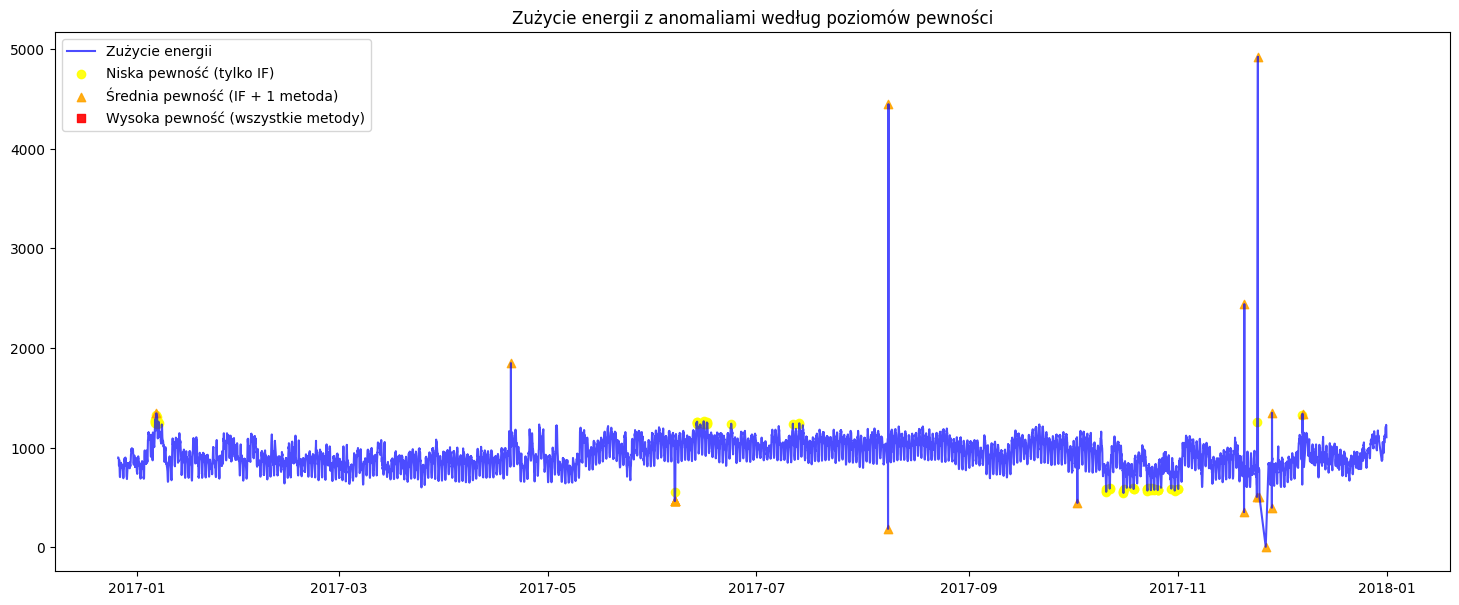

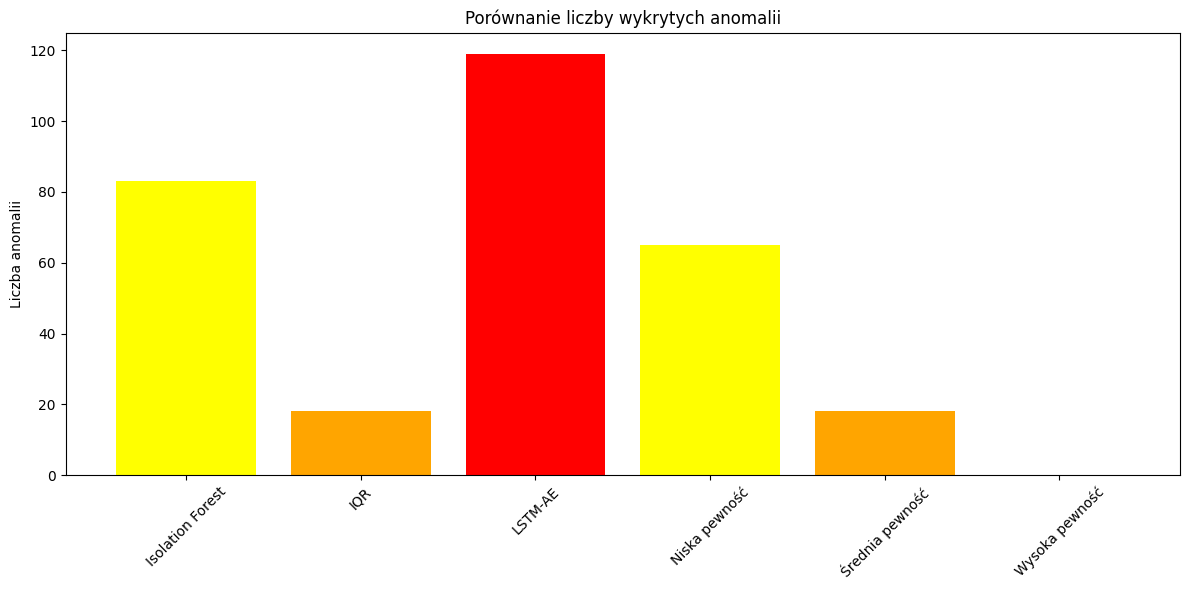

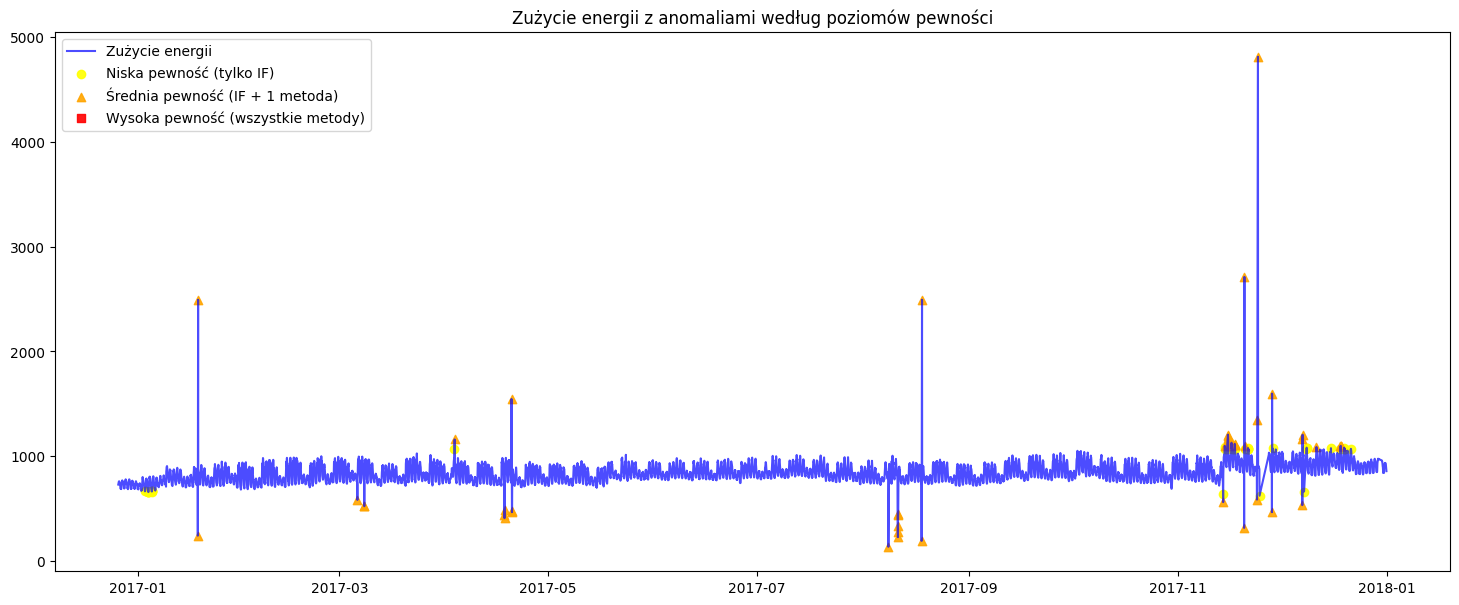

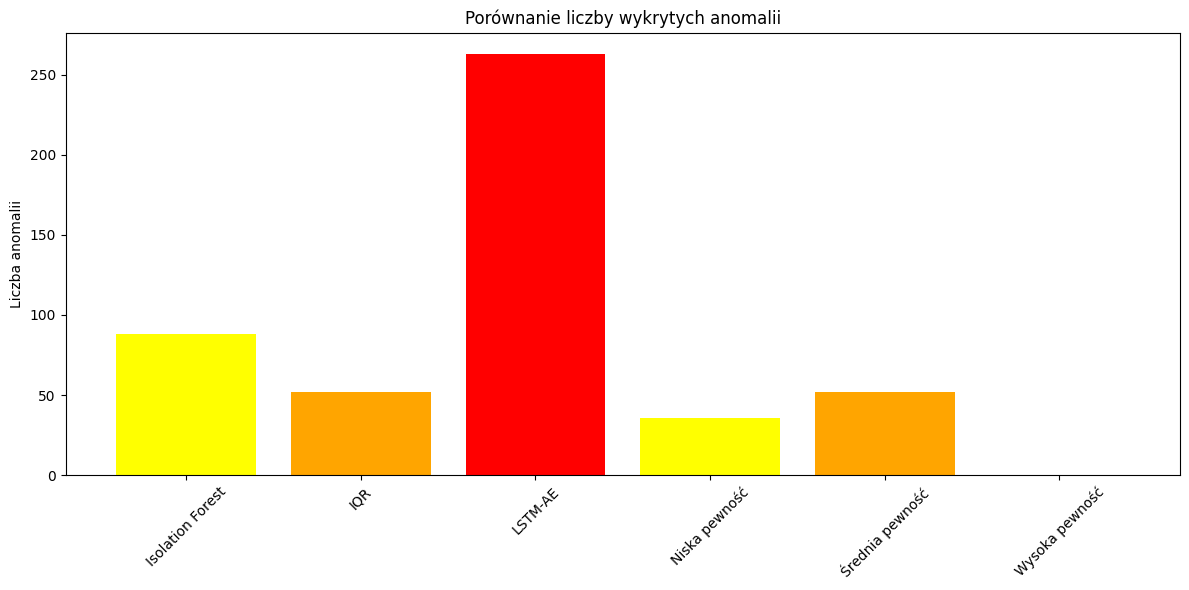

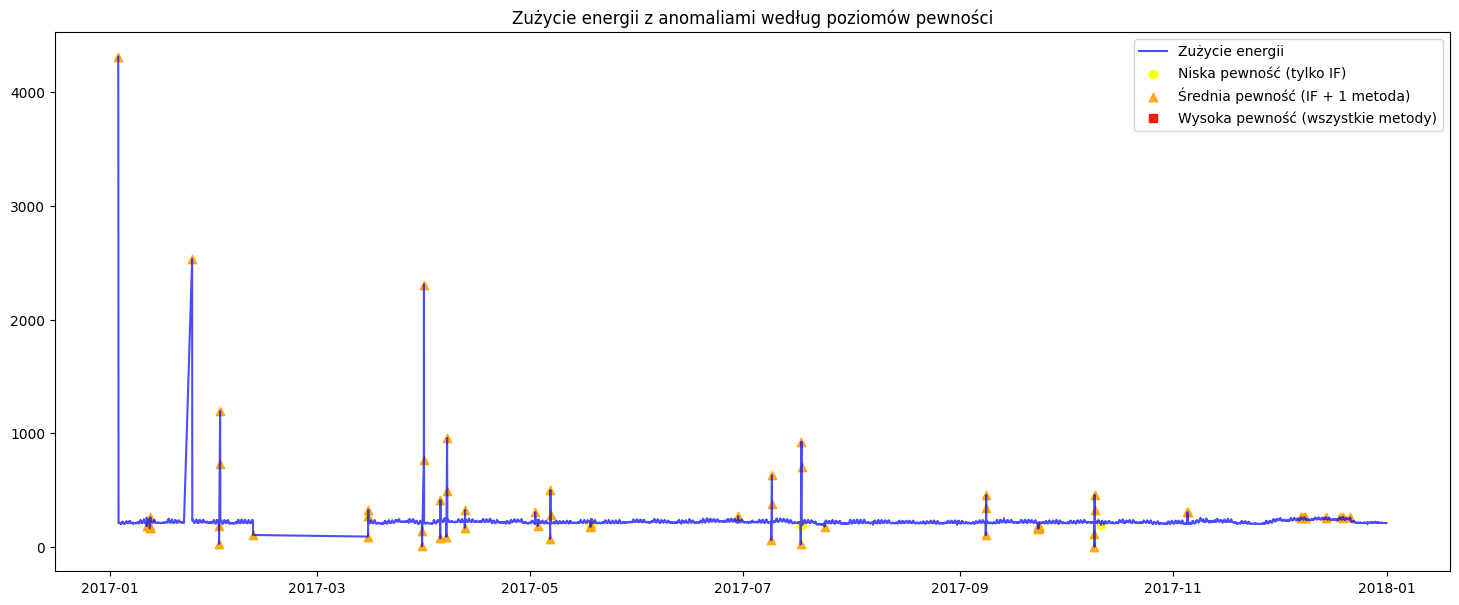

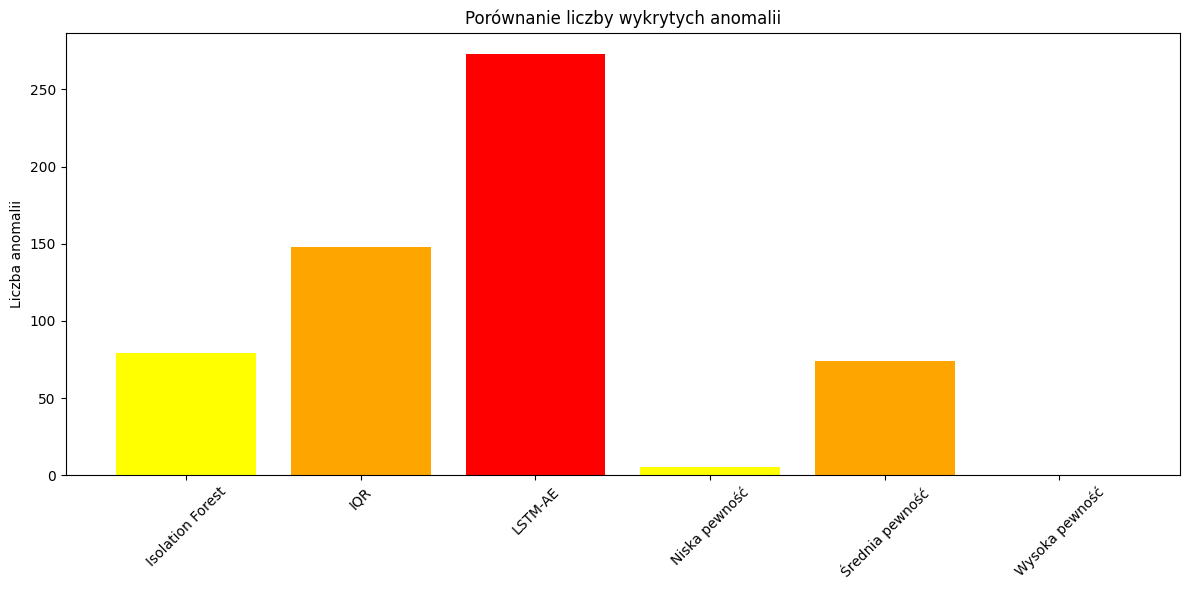

In [509]:


def plotAll(dat, IF, LSTM, IQR):
    plt.figure(figsize=(18, 7))
    plt.plot(dat.index, dat['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.7)

    consensus = assign_consensus_labels(
        IF['isolation_forest'] == 1,
        None,
        IQR
    )

    # Zaznaczanie anomalii według poziomów pewności
    low_anomalies = dat.loc[consensus['low'] & ~consensus['medium']]
    medium_anomalies = dat.loc[consensus['medium'] & ~consensus['high']]
    high_anomalies = dat.loc[consensus['high']]

    plt.scatter(low_anomalies.index, low_anomalies['energy_consumption'],
                label="Niska pewność (tylko IF)", color='yellow', alpha=0.9, marker='o')

    plt.scatter(medium_anomalies.index, medium_anomalies['energy_consumption'],
                label="Średnia pewność (IF + 1 metoda)", color='orange', alpha=0.9, marker='^')

    plt.scatter(high_anomalies.index, high_anomalies['energy_consumption'],
                label="Wysoka pewność (wszystkie metody)", color='red', alpha=0.9, marker='s')

    plt.title('Zużycie energii z anomaliami według poziomów pewności')
    plt.legend()

    plt.figure(figsize=(12, 6))

    counts = {
        'Isolation Forest': sum(IF['isolation_forest'] == 1),
        'IQR': sum(IQR),
        'LSTM-AE': sum(LSTM['lstm_autoencoder'] == 1),
        'Niska pewność': sum(consensus['low'] & ~consensus['medium']),
        'Średnia pewność': sum(consensus['medium'] & ~consensus['high']),
        'Wysoka pewność': sum(consensus['high'])
    }

    colors = ['yellow', 'orange', 'red', 'yellow', 'orange', 'red']
    plt.bar(counts.keys(), counts.values(), color=colors)
    plt.title('Porównanie liczby wykrytych anomalii')
    plt.ylabel('Liczba anomalii')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

plotAll(d, resIF, resLSTM, resIQR)
plotAll(d2, resIF2, resLSTM2, resIQR2)
plotAll(d3, resIF3, resLSTM3, resIQR3)

In [552]:
d4 = load_and_preprocess('anomaly_two.csv')[-1000:-500]
d4 = d4.set_index("timestamp")
d4_lstm4 = d4
resIF4 = isolation_forest_IQR(data=d4)
# resLSTM4 = lstm_autoencoder(d4_lstm4, window_size=24, iqr_multiplier=4.5)
t4, resIQR4 = dynamic_iqr(d4['energy_consumption'], w=None, k=1.5)

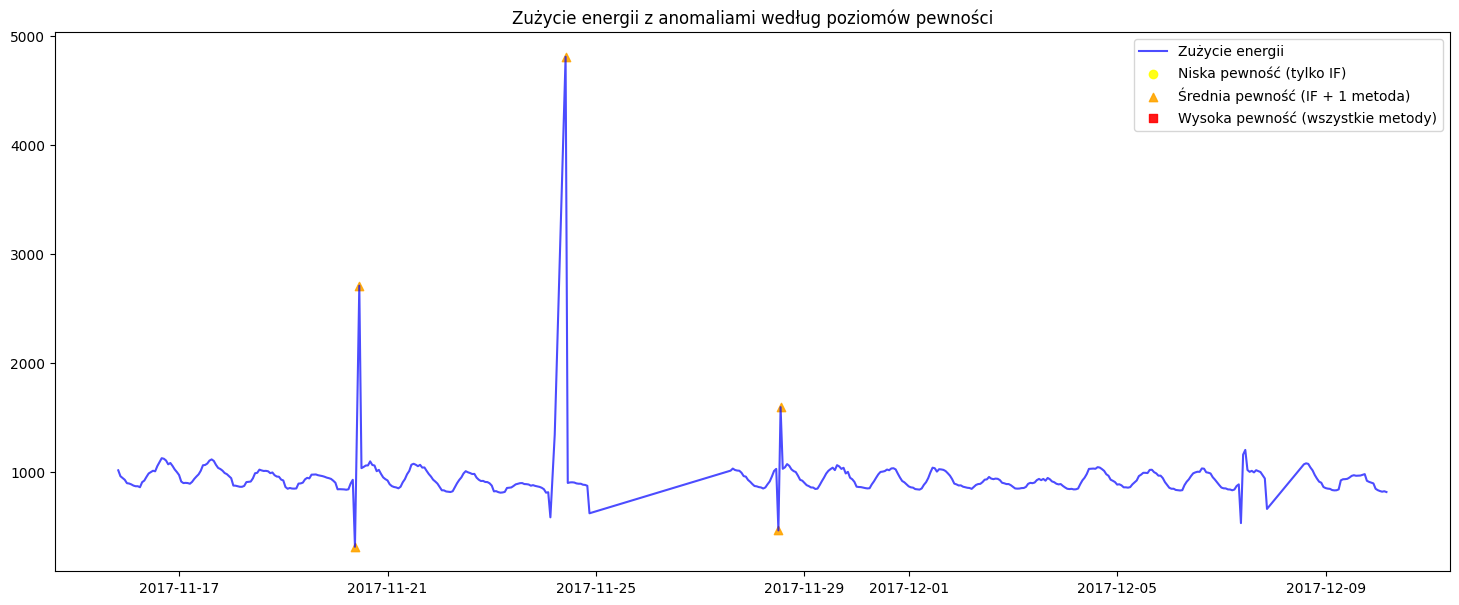

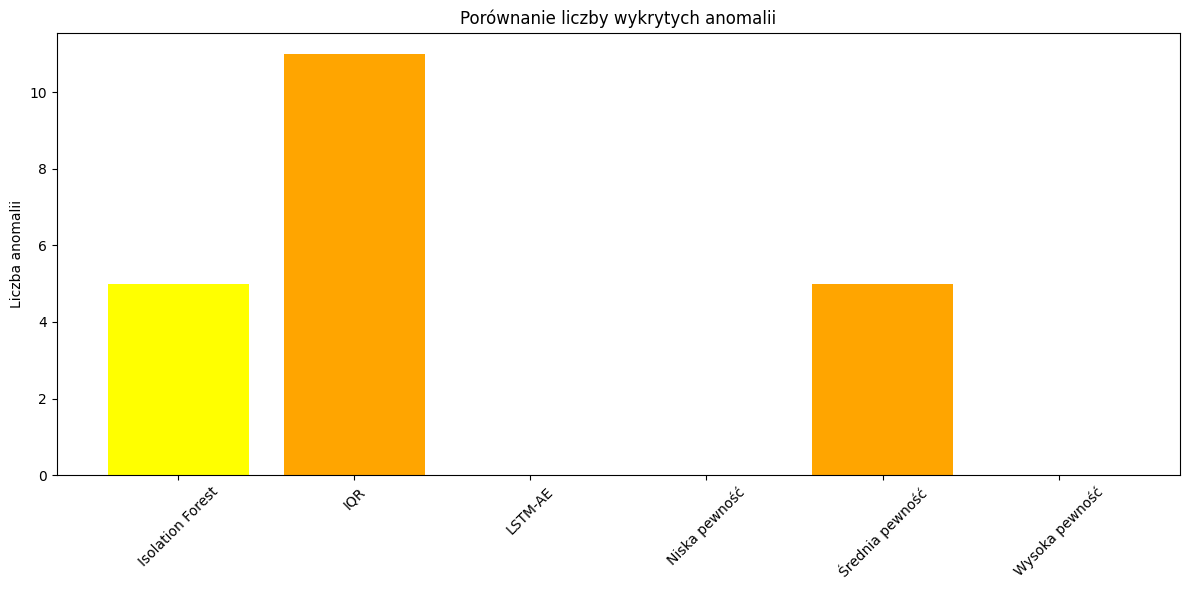

In [553]:
plotAll(d4, resIF4, resLSTM4, resIQR4)